# <span style='color:SteelBlue'>PB7 - Scoring client de banque (part 1)</span>

![Logo pret_a_depenser](https://user.oc-static.com/upload/2023/03/22/16794938722698_Data%20Scientist-P7-01-banner.png)

# <span style='background:white; color:black'>Sommaire</span>

**Introduction**

Importations des librairies<br>

Paramètres d'affichage<br>

Fonctions <br>

Importation des données <br>

**Etape 1 : Présentation du dataset**

**Etape 2 : Feature engineering et jointure**

**Etape 3 : Nettoyage des données**
- 1/ Filtrage des valeurs infinies
- 2/ Filtrage des features à valeur unique
- 3/ Filtrage par taux de remplissage
- 4/ Transformation des booléens en numérique
- 5/ Filtrage des features corrélées
- 6/ Séparation des datasets de train_test
- 7/ Cast de la target

**Etape 4 : Exportation des dataframes nettoyés**

**Conclusion**

# <span style='background:blue'>Introduction</span>

L'entreprise **"Prêt à dépenser"** souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un **algorithme de classification** en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).
___
**Missions**<br>
1/ Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.

2/ Analyser les features qui contribuent le plus au modèle, d’une manière générale (feature importance globale) et au niveau d’un client (feature importance locale), afin, dans un soucis de transparence, de permettre à un chargé d’études de mieux comprendre le score attribué par le modèle.

3/ Mettre en production le modèle de scoring de prédiction à l’aide d’une API et réaliser une interface de test de cette API.

4/ Mettre en oeuvre une approche globale MLOps de bout en bout, du tracking des expérimentations à l’analyse en production du data drift.
___
Ce notebook presente la 1ère partie concernant la présentation et le nettoyage du dataset.

___

**Source des datasets**<br>
Home Credit est une institution financière internationale de prêts à la consommation. Elle nous fournit un jeu de données comportant des informations sur les clients, les crédits qu'ils ont contractés, leur revenus, etc. Ces données sont utilisées pour construire un modèle de scoring de crédit pour prédire la probabilité de capacité de remboursement d'un client, et donc de déterminer si un crédit doit lui être accordé ou non.

Source : [Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk/overview) sur Kaggle.com<br>

10 fichiers CSV :
- application_train.csv
- application_test.csv
- bureau.csv
- bureau_balance.csv
- credit_card_balance.csv
- HomeCredit_columns_description.csv
- installments_payments.csv
- POS_CASH_balance.csv
- previous_application.csv
- sample_submission.csv

Voici le diagramme entité-association des données (diagramme ERD) :

![mappage_dataset](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

# <span style='background:grey'>Importations des librairies utilisees dans ce notebook</span>

In [1]:
# Librairies generales
import sys
import os
import time
from datetime import datetime
import pickle
import re

# Data science
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# machine learning
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, ColumnTransformer

# Affichage plot dans le notebook
%matplotlib inline

# Versions
print("Version des librairies utilisees :")
print("Python        : " + sys.version)
print("Matplotlib    : " + mpl.__version__)
print("Missingno     : " + msno.__version__)
print("Numpy         : " + np.__version__)
print("Pandas        : " + pd.__version__)
print("Scikit-learn  : " + sklearn.__version__)
print("Seaborn       : " + sns.__version__)

# Afficher heure lancement
maintenant = datetime.now().isoformat()
print("\nCode lance le : " + maintenant)

# Enregistrer l'heure de debut
start_time = time.time()

# Activer la verification PEP8
print("")
%load_ext pycodestyle_magic
%pycodestyle_on

Version des librairies utilisees :
Python        : 3.12.2 (tags/v3.12.2:6abddd9, Feb  6 2024, 21:26:36) [MSC v.1937 64 bit (AMD64)]
Matplotlib    : 3.8.2
Missingno     : 0.5.2
Numpy         : 1.26.4
Pandas        : 2.2.0
Scikit-learn  : 1.4.0
Seaborn       : 0.13.2

Code lance le : 2024-03-08T08:00:32.981112



# <span style='background:grey'>Paramètres d'affichage</span>

In [2]:
# nombre ligne, col et chiffre apres la virgule
pd.set_option("display.max_row", 150)
pd.set_option("display.max_column", 150)
pd.set_option("display.precision", 2)

# <span style='background:grey'>Fonctions</span>

In [3]:
def calculer_duree_notebook(start_time):
    """
    Cette procédure calcule et affiche la durée totale depuis un temps de
    début donné.

    Args:
        start_time (float): Le temps de début en secondes depuis l'époque.

    Returns:
        None
    """
    # Calculer la durée totale et convertir en minutes et secondes
    minutes, seconds = divmod(time.time() - start_time, 60)

    # Afficher la durée totale
    print(f"Durée execution notebook : {int(minutes)} min {int(seconds)} sec")

In [4]:
def calcul_valeur_manquante(df):
    """
    Calcule le nombre total de valeurs manquantes dans le DataFrame.

    :param df: DataFrame à analyser
    :return: nombre total de valeurs manquantes, nombre total de données,
    pourcentage de valeurs manquantes
    """
    nb_nan_tot = df.isna().sum().sum()
    nb_donnees_tot = np.prod(df.shape)
    nb_nan_pourcent = round((nb_nan_tot / nb_donnees_tot) * 100, 2)
    return nb_nan_tot, nb_donnees_tot, nb_nan_pourcent

In [5]:
def calcul_valeur_manquante_table(df):
    """
    Crée une table des valeurs manquantes par colonne dans le DataFrame.

    :param df: DataFrame à analyser
    :return: DataFrame contenant le nombre et le pourcentage de valeurs
    manquantes par colonne
    """
    nan_nbr = df.isnull().sum()
    nan_pourcent = nan_nbr / len(df) * 100
    table = pd.concat([nan_nbr, nan_pourcent.round(2)], axis=1)
    table.columns = ['Nombre de valeurs manquantes', '% de valeurs manquantes']
    return table

In [6]:
def valeur_manquante_text_graph(df, tableau, matrice):
    """
    Affiche le nombre de valeurs manquantes, un tableau de la répartition des
    valeurs manquantes par variable,
    et une matrice de répartition des valeurs manquantes par variable.

    :param df: DataFrame à analyser
    :param tableau: si True, affiche le tableau de répartition des valeurs
    manquantes
    :param matrice: si True, affiche la matrice de répartition des valeurs
    manquantes
    """
    # Affichage des valeurs manquantes
    nb_nan_tot, nb_donnees_tot, nb_nan_pourcent = calcul_valeur_manquante(df)
    print('Valeurs manquantes (Nan) : {0} / {1} données ({2} %)'.format(
        nb_nan_tot, nb_donnees_tot, nb_nan_pourcent
    ))

    # Affichage du tableau de répartition des valeurs manquantes
    table = calcul_valeur_manquante_table(df)
    nb_col = df.columns.size
    nb_col_nan = table[table['Nombre de valeurs manquantes'] != 0][
        'Nombre de valeurs manquantes'].size
    print(f'{nb_col_nan} / {nb_col} colonne(s) concernée(s)')

    # Affichage du tableau de répartition des valeurs manquantes
    if tableau:
        display(
            table[table['Nombre de valeurs manquantes'] != 0]
            .sort_values('% de valeurs manquantes', ascending=False)
            .style.background_gradient('YlGn')
        )

    # Affichage de la matrice de répartition des valeurs manquantes
    if matrice:
        print("-" * 100)
        print("Heatmap de visualisation des valeurs manquantes")
        msno.matrix(df)

In [7]:
%pycodestyle_off
def encode_feature_cat(df):
    """
    Cette fonction encode les features catégorielles d'un DataFrame.
    Si une feature a 2 catégories ou moins, elle utilise le LabelEncoder.
    Sinon, elle utilise le One-Hot Encoding.

    Paramètres :
    df (pandas.DataFrame) : Le DataFrame à encoder.

    Retourne :
    df (pandas.DataFrame) : Le DataFrame avec les features encodées.
    labelencoder_col (list) : La liste des features encodées avec le LabelEncoder.
    one_hot_col (list) : La liste des features encodées avec le One-Hot Encoding.
    """
    # Liste des colonnes originales
    original_columns = list(df.columns)

    # Création d'un label encoder
    le = LabelEncoder()

    # Création de listes vides
    labelencoder_col, one_hot_col = [], []

    # POUR chaque feature de type 'object'
    for col in df:
        if df[col].dtype == 'object':

            # SI <= 2 catégories ALORS Labelencoder
            if len(list(df[col].unique())) <= 2:
                le.fit(df[col])
                df[col] = le.transform(df[col])
                labelencoder_col.append(col)

            # SINON One-hot encoding et vérification nom des cols crées
            else:
                df = pd.get_dummies(df, columns=[col], dummy_na=False)
                df = df.rename(columns=lambda x:re.sub(
                    '[^A-Za-z0-9_]+',
                    ' ',
                    x
                ))

    # Ajouter les nouvelles col du One hot encoder à la liste
    one_hot_col += [c for c in df.columns if c not in original_columns]

    # Affichage
    print(f'{len(labelencoder_col)} feature(s) ont subie(s) le LabelEncoder:')
    for column in labelencoder_col:
        print(column)
    print('')

    print(f"Nombre de nouvelles features avec One-Hot : {len(one_hot_col)}")
    for column in one_hot_col:
        print(column)

    return df, labelencoder_col, one_hot_col
%pycodestyle_on

In [8]:
def feature_engin_application_train_test(app_train, app_test):
    """
    Cette fonction effectue l'ingénierie des features sur les datasets de
    train et de test. Elle concatène les deux datasets, supprime les lignes
    avec un CODE_GENDER aberrant, encode les features catégorielles, supprime
    les valeurs aberrantes pour la feature DAYS_EMPLOYED, et crée de nouvelles
    features en calculant différents ratios.

    Paramètres :
    app_train (pandas.DataFrame) : Le DataFrame de train.
    app_test (pandas.DataFrame) : Le DataFrame de test.

    Retourne :
    df (pandas.DataFrame) : Le DataFrame avec les features modifiées et
    ajoutées.

    """
    # Concatenation des 2 datasets
    df = pd.concat([app_train, app_test]).reset_index()

    # Suppression des lignes avec un CODE_GENDER abérant
    df = df[df['CODE_GENDER'] != 'XNA']

    # Encodage des features catégorielles (LabelEncoder ou One-Hot)
    df, labelencoder_col, one_hot_col = encode_feature_cat(df)

    # Suppression valeur abérantes pour la feature DAYS_EMPLOYED
    df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace(365243, np.nan)

    # Création de nouvelles features (ratio en %)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

    return df

In [9]:
def feature_engin_bureau_balance(bureau, bureau_balance):
    """
    Cette fonction effectue plusieurs opérations d'agrégation sur les données
    de bureau et de balance de bureau. Elle encode d'abord les
    caractéristiques catégorielles, puis crée plusieurs aggrégations
    numériques et catégorielles. Ensuite, elle joint les données agrégées
    sur 'SK_ID_CURR'. Enfin, elle effectue des aggrégations séparées pour les
    crédits actifs et fermés.

    Paramètres:
    bureau (pd.DataFrame): DataFrame contenant les données de bureau
    bureau_balance (pd.DataFrame): DataFrame contenant les données de balance
    de bureau

    Retourne:
    bureau_agg (pd.DataFrame): DataFrame contenant les données agrégées
    """
    # Encodage des features catégorielles (LabelEncoder ou One-Hot)
    bureau_cat, b_label_col, b_one_hot_col = encode_feature_cat(bureau)
    print('-' * 50)
    bb_cat, bb_label_col, bb_one_hot_col = encode_feature_cat(bureau_balance)

    # Dictionnaire des aggrégations
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_one_hot_col:
        bb_aggregations[col] = ['mean']

    # Grouper par SK_ID_BUREAU et renommage des features
    bb_agg = bb_cat.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index(
        [e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()]
    )

    # Jointure df bureau_cat & bb_agg (sur SK_ID_BUREAU qui est del ensuite)
    bureau_cat = bureau_cat.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau_cat.drop(['SK_ID_BUREAU'], axis=1, inplace=True)

    # Suppression des variables pour libérer de la mémoire
    del bb_cat, bb_agg

    # Création des aggrégations des features numériques
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }

    # Création des aggrégations des features catégorielles
    cat_aggregations = {}

    for col in b_one_hot_col:
        cat_aggregations[col] = ['mean']

    for col in bb_one_hot_col:
        cat_aggregations[col + "_MEAN"] = ['mean']

    # Aggrégation du df bureau_cat par SK_ID_CURR et rennomage des features
    bureau_agg = bureau_cat.groupby('SK_ID_CURR').agg(
        {**num_aggregations, **cat_aggregations}
    )
    bureau_agg.columns = pd.Index([
        'BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()
    ])

    # Aggregation des credit actifs (que variables numériques)
    active = bureau_cat[bureau_cat['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(
        ['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()]
    )
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg

    # Aggregation des credit cloturés (que variables numériques)
    closed = bureau_cat[bureau_cat['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(
        ['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()]
    )
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')

    return bureau_agg

73:80: E501 line too long (80 > 79 characters)
80:80: E501 line too long (84 > 79 characters)
89:80: E501 line too long (84 > 79 characters)


In [10]:
def feature_engin_credit_card_balance(cc):
    """
    Cette fonction effectue plusieurs opérations d'agrégation sur les données
    de carte de crédit. Elle encode d'abord les caractéristiques
    catégorielles, puis supprime la caractéristique 'SK_ID_PREV'. Ensuite,
    elle groupe les données par 'SK_ID_CURR' et calcule plusieurs
    statistiques. Enfin, elle crée une nouvelle caractéristique qui compte
    le nombre de lignes par 'SK_ID_CURR'.

    Paramètres:
    cc (pd.DataFrame): DataFrame contenant les données de carte de crédit

    Retourne:
    cc_agg (pd.DataFrame): DataFrame contenant les données agrégées
    """
    # Encodage des features catégorielles (LabelEncoder ou One-Hot)
    cc_cat, cc_label_col, cc_one_hot_col = encode_feature_cat(cc)

    # Suppression de la feature 'SK_ID_PREV'
    cc_cat.drop(['SK_ID_PREV'], axis=1, inplace=True)

    # Aggrégation par 'SK_ID_CURR' et renommage des features
    cc_agg = cc_cat.groupby('SK_ID_CURR').agg(
        ['min', 'max', 'mean', 'sum', 'var']
    )
    cc_agg.columns = pd.Index(
        ['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()]
    )

    # Création de nouvelles features (nombre de lignes par 'SK_ID_CURR')
    cc_agg['CC_COUNT'] = cc_cat.groupby('SK_ID_CURR').size()

    return cc_agg

In [11]:
def feature_engin_credit_installments_payments(ins):
    """
    Cette fonction effectue plusieurs opérations d'agrégation sur les données
    de versement. Elle crée de nouvelles caractéristiques. Ensuite, elle
    groupe les données par 'SK_ID_CURR' et calcule plusieurs statistiques.
    Enfin, elle crée une nouvelle caractéristique qui compte le nombre de
    lignes par 'SK_ID_CURR'.

    Paramètres:
    ins (pd.DataFrame): DataFrame contenant les données de
    installments_payments

    Retourne:
    ins_agg (pd.DataFrame): DataFrame contenant les données agrégées
    """
    # Création de nouvelles features (ratio en % et différence)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']

    # Nombre de jour de retard avant l'échéance (pas de valeurs négatives)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)

    # Nombre de jours avant l'échéance (pas de valeurs négatives)
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)

    # Création des aggrégations des features numériques
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum']
    }

    # Aggrégation par 'SK_ID_CURR' et renommage des features
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index([
        'INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()
    ])

    # Création de nouvelles features (nombre de lignes par 'SK_ID_CURR')
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()

    return ins_agg

In [12]:
def feature_engin_pos_cash_balance(pos):
    """
    Cette fonction effectue plusieurs opérations d'agrégation sur les données
    POS. Elle encode d'abord les caractéristiques catégorielles, puis crée
    des agrégations pour les caractéristiques numériques et catégorielles.
    Ensuite, elle groupe les données par 'SK_ID_CURR' et calcule plusieurs
    statistiques. Enfin, elle crée une nouvelle caractéristique qui compte
    le nombre de lignes par 'SK_ID_CURR'.

    Paramètres:
    pos (pd.DataFrame): DataFrame contenant les données POS

    Retourne:
    pos_agg (pd.DataFrame): DataFrame contenant les données agrégées
    """
    # Encodage des features catégorielles (LabelEncoder ou One-Hot)
    pos_cat, pos_label_col, pos_one_hot_col = encode_feature_cat(pos)

    # Création des aggrégations des features numériques
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }

    # Création des aggrégations des features catégorielles
    for col in pos_one_hot_col:
        aggregations[col] = ['mean']

    # Aggrégation par 'SK_ID_CURR' et renommage des features
    pos_agg = pos_cat.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index([
        'POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()
    ])

    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos_cat.groupby('SK_ID_CURR').size()

    return pos_agg

In [13]:
def feature_engin_previous_application(prev, valeur_aberante_feat):
    """
    Cette fonction effectue plusieurs opérations sur le DataFrame 'prev' :
    - Encodage des features catégorielles
    - Suppression des valeurs aberrantes pour plusieurs features 'DAYS'
    - Création d'une nouvelles feature
    - Création des aggrégations des features numériques et catégorielles
    - Aggrégation par 'SK_ID_CURR' et renommage des features
    - Aggrégation des crédits actifs et des crédits clôturés

    Args:
        prev (pd.DataFrame): Le DataFrame sur lequel effectuer les opérations.
        valeur_aberante_feat (list): Liste des features 'DAYS' pour lesquelles
        supprimer les valeurs aberrantes.

    Returns:
        prev_agg (pd.DataFrame): Le DataFrame après l'application de toutes
        les opérations.
    """
    # Encodage des features catégorielles (LabelEncoder ou One-Hot)
    prev_cat, prev_label_col, prev_one_hot_col = encode_feature_cat(prev)

    # Suppression valeur abérantes pour plusieurs features de type 'DAYS'
    for col in valeur_aberante_feat:
        prev_cat[col] = prev_cat[col].replace(365243, np.nan)

    # Création d'une nouvelle feature (ratio en %)
    prev_cat['APP_CREDIT_PERC'] = (
        prev_cat['AMT_APPLICATION'] / prev_cat['AMT_CREDIT']
    )

    # Création des aggrégations des features numériques
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }

    # Création des aggrégations des features catégorielles
    cat_aggregations = {}
    for col in prev_one_hot_col:
        cat_aggregations[col] = ['mean']

    # Aggrégation par 'SK_ID_CURR' et renommage des features
    prev_agg = prev_cat.groupby('SK_ID_CURR').agg(
        {**num_aggregations, **cat_aggregations}
    )
    prev_agg.columns = pd.Index([
        'PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()
    ])

    # Aggregation des credit approuvées (que variables numériques)
    approved = prev_cat[prev_cat['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index([
        'APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()
    ])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')

    # Aggregation des credit refusés (que variables numériques)
    refused = prev_cat[prev_cat['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index([
        'REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()]
    )
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')

    return prev_agg

63:80: E501 line too long (86 > 79 characters)
71:80: E501 line too long (85 > 79 characters)


In [1]:
def detecteur_correlation_sup_target(
    corr_matrix,
    target_feature=None,
    seuil=0.5
):
    """
    Cette fonction détecte et affiche les corrélations
    (positives et négatives) supérieures à un seuil
    donné dans une matrice de corrélation impliquant une feature cible donnée.

    :param corr_matrix: La matrice de corrélation (df)
    :param target_feature: La feature cible pour laquelle les corrélations
    sont calculées (str) (optionnelle)
    :param seuil: Le seuil de corrélation à partir duquel une paire de
    variables est considérée comme corrélée (par défaut 0.5) (int)
    """

    # Créer un ensemble pour stocker les features déjà traitées
    deja_traites = set()

    # Créer une liste pour stocker les corrélations supérieures au seuil
    corr_sup_seuil = []

    # SI une feature cible est spécifiée
    if target_feature:

        # Parcourir la matrice de corrélation en fonction de la feature cible
        for feature1 in corr_matrix.columns:
            if feature1 != target_feature and feature1 not in deja_traites:

                # SI la valeur absolue de la corrélation est supérieure au seuil
                if abs(corr_matrix.loc[target_feature, feature1]) > seuil:

                    # Ajout la paire de features et la corrélation à la liste
                    corr_sup_seuil.append([
                        target_feature,
                        feature1,
                        round(corr_matrix.loc[target_feature, feature1], 2)
                    ])

                # Ajout la paire à l'ensemble des paires déjà traitées
                deja_traites.add(feature1)
    else:
        # Parcourir la matrice de corr pour toutes les paires de features
        for feature1 in corr_matrix.columns:
            for feature2 in corr_matrix.columns:

                # SI features sont différentes ET paire pas déjà été traitée
                if feature1 != feature2 and feature2 not in deja_traites:

                    # SI la valeur absolue de la corrélation est supérieure au seuil
                    if abs(corr_matrix.loc[feature1, feature2]) > seuil:

                        # Ajout la paire de features et la corrél. à la liste
                        corr_sup_seuil.append([
                            feature1,
                            feature2,
                            round(corr_matrix.loc[feature1, feature2], 2)
                        ])

                    # Ajout la paire à l'ensemble des paires déjà traitées
                    deja_traites.add(feature1)

    # Créez un DataFrame à partir de la liste des corrélations
    corr_df = pd.DataFrame(
        corr_sup_seuil,
        columns=['Feature cible', 'Feature associée', 'Corrélation']
    )

    # Trier le DataFrame par 'Corrélation' en ordre décroissant
    corr_df = corr_df.sort_values(by='Corrélation', ascending=False)

    # Afficher les corrélations supérieures au seuil
    display(corr_df)

In [15]:
def supprimer_caracteristiques_corr(corr_matrix, seuil=0.9):
    """
    Supprime les caractéristiques fortement corrélées dans un DataFrame.

    Paramètres:
    corr_matrix (DataFrame): Matrice de corrélation des caractéristiques.
    seuil (float): Seuil de corrélation pour déterminer quelles caractéristiques supprimer.

    Retourne:
    df_to_drop (DataFrame): DataFrame contenant les caractéristiques à supprimer.
    """

    # Filtrer la matrice de corrélation
    high_corr = corr_matrix[corr_matrix > seuil]

    # Aplatir la matrice de corrélation en une série
    corr_series = high_corr.unstack()

    # Supprimer les valeurs NA et les doublons (car symetrique)
    corr_series = corr_series.dropna().drop_duplicates()

    # Trier la série par ordre décroissant
    sorted_corr = corr_series.sort_values(ascending=False)

    # Convertir la série en DataFrame et afficher les 50 premières lignes
    df_sorted_corr = sorted_corr.head(100).to_frame()
    df_sorted_corr.columns = ['Corrélation']
    display(df_sorted_corr)

    # Trouver les paires de caractéristiques à supprimer
    to_drop = set()
    for feature1, feature2 in corr_series.index:
        if corr_series[(feature1, feature2)] > seuil:
            to_drop.add(feature1 if feature1 in to_drop else feature2)

    # Convertir l'ensemble des caractéristiques à supprimer en DataFrame
    df_to_drop = pd.DataFrame(list(to_drop), columns=['Feature à supprimer'])

    # Trier le DataFrame par ordre alphabétique
    df_to_drop = df_to_drop.sort_values(by='Feature à supprimer')

    return df_to_drop, to_drop

7:80: E501 line too long (91 > 79 characters)
10:80: E501 line too long (81 > 79 characters)


In [16]:
class BooleanToInt(BaseEstimator, TransformerMixin):
    """
    Transformateur personnalisé pour convertir les valeurs booléennes en
    entiers.

    Hérite de BaseEstimator et TransformerMixin de sklearn.base pour
    bénéficier des méthodes utiles pour les transformateurs personnalisés.

    Méthodes:
    fit(X, y=None) : Apprend les noms des caractéristiques à partir de X.
    Retourne self.
    transform(X) : Convertit les valeurs booléennes en entiers et retourne
    le résultat sous forme de DataFrame.
    get_feature_names_out(input_features=None) : Retourne les noms des
    caractéristiques apprises lors de l'appel à fit().
    """

    def fit(self, X, y=None):
        """
        Apprend les noms des caractéristiques à partir de X.

        Paramètres:
        X (DataFrame) : Les données d'entrée.
        y (None) : Non utilisé.

        Retourne:
        self
        """
        self.feature_names_ = X.columns
        return self

    def transform(self, X):
        """
        Convertit les valeurs booléennes en entiers et retourne le résultat
        sous forme de DataFrame. Ignore les valeurs NaN.

        Paramètres:
        X (DataFrame) : Les données d'entrée.

        Retourne:
        DataFrame : Les données transformées.
        """
        # Crée une copie de X pour éviter de modifier les données originales
        X_copy = X.copy()

        # Pour chaque colonne dans X_copy
        for col in X_copy.columns:

            # Si la colonne contient des valeurs booléennes
            if X_copy[col].dtype == bool:

                # Convertit les valeurs booléennes en entiers
                X_copy[col] = X_copy[col].astype(int)

        return X_copy

    def get_feature_names_out(self, input_features=None):
        """
        Retourne les noms des caractéristiques apprises lors de l'appel à
        fit().

        Paramètres:
        input_features (None) : Non utilisé.

        Retourne:
        list : Les noms des caractéristiques.
        """
        return self.feature_names_

# <span style='background:grey'>Importation des donnees</span>

Importation des fichiers CSV avec Pandas

In [17]:
# Definir le chemin des datasets
chemin = "./data/source/"

# Obtenir une liste de tous les fichiers dans le repertoire
fichiers = os.listdir(chemin)

# Initialiser un dictionnaire vide
data_brut = {}

# Chemin du fichier pickle
pickle_path = chemin + 'data_brut.pickle'

# Vérifier si le fichier pickle existe
if os.path.exists(pickle_path):

    # Charger les données à partir du fichier pickle
    with open(pickle_path, 'rb') as handle:
        data_brut = pickle.load(handle)
    print("===> Données chargées à partir du fichier pickle <====\n")
else:
    print("===> Liste des fichiers importes: <====\n")

    # Boucle sur chaque fichier
    for fichier in fichiers:

        # Traiter uniquement les fichiers .csv
        if fichier.endswith(".csv"):
            print(fichier)

            # Lire le fichier csv et le stocker dans le dictionnaire
            data_brut[fichier] = pd.read_csv(
                chemin + fichier,
                sep=",",
                encoding="latin-1"
            )

    # Sauvegarder les données dans un fichier pickle
    with open(pickle_path, 'wb') as handle:
        pickle.dump(data_brut, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("\n===> Données sauvegardées dans un fichier pickle <====\n")

===> Données chargées à partir du fichier pickle <====



# <span style='background:blue'>Etape 1 : Présentation du dataset</span>

## <span style='background:green'>1/ application_train</span>

### <span style='background:purple'>a/ Aperçu tableau</span>

Nous affichons un apercu du début et de la fin du dataframe, ainsi que des lignes au hasard.

In [15]:
# isoler le contenu du fichier et afficher le contenu
nom_fichier = "application_train.csv"
app_train = data_brut[nom_fichier]
app_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,4.07e+05,24700.5,3.51e+05,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,1.88e-02,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.08,0.26,0.14,0.02,0.04,0.97,0.62,1.43e-02,0.00,0.07,0.08,0.12,0.04,0.02,1.90e-02,0.00e+00,0.00e+00,0.03,0.04,0.97,0.63,1.44e-02,0.00,0.07,0.08,0.12,3.77e-02,0.02,1.98e-02,0.0,0.00,0.03,0.04,0.97,0.62,1.44e-02,0.00,0.07,0.08,0.12,0.04,0.02,1.93e-02,0.00e+00,0.00,reg oper account,block of flats,1.49e-02,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1.29e+06,35698.5,1.13e+06,Family,State servant,Higher education,Married,House / apartment,3.54e-03,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.31,0.62,NaN,0.10,0.05,0.99,0.80,6.05e-02,0.08,0.03,0.29,0.33,0.01,0.08,5.49e-02,3.90e-03,9.80e-03,0.09,0.05,0.99,0.80,4.97e-02,0.08,0.03,0.29,0.33,1.28e-02,0.08,5.54e-02,0.0,0.00,0.10,0.05,0.99,0.80,6.08e-02,0.08,0.03,0.29,0.33,0.01,0.08,5.58e-02,3.90e-03,0.01,reg oper account,block of flats,7.14e-02,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,1.35e+05,6750.0,1.35e+05,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,1.00e-02,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.56,0.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0

In [16]:
app_train.sample(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
282643,427380,0,Revolving loans,F,N,Y,2,180000.0,2.02e+05,10125.0,2.02e+05,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,5.31e-03,-15122,-1149,-7980.0,-5260,NaN,1,1,0,1,0,0,Sales staff,4.0,2,2,FRIDAY,11,0,0,0,0,1,1,Trade: type 7,0.42,0.57,0.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,-855.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
39786,146076,0,Cash loans,M,Y,Y,0,90000.0,3.38e+05,26248.5,3.38e+05,Unaccompanied,Working,Higher education,Married,House / apartment,3.58e-02,-18849,-5560,-5820.0,-2405,20.0,1,1,1,1,1,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Business Entity Type 1,0.50,0.68,0.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1705.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0
55566,164387,0,Cash loans,F,N,Y,0,90000.0,6.29e+05,25087.5,5.62e+05,Family,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,2.52e-02,-17990,-2178,-218.0,-1537,NaN,1,1,0,1,0,0,NaN,2.0,2,2,TUESDAY,9,0,1,1,0,1,1,Business Entity Type 3,0.55,0.50,0.40,0.02,NaN,0.99,NaN,NaN,NaN,0.1,0.04,NaN,NaN,NaN,0.02,NaN,0.0,0.02,NaN,0.99,NaN,NaN,NaN,0.1,0.04,NaN,NaN,NaN,0.02,NaN,0.0,0.02,NaN,0.99,NaN,NaN,NaN,0.1,0.04,NaN,NaN,NaN,0.02,NaN,0.0,NaN,block of flats,0.01,NaN,No,2.0,1.0,2.0,1.0,-701.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
220859,355850,0,Cash loans,M,N,N,0,378000.0,1.93e+06,71460.0,1.80e+06,"Spouse, partner",Commercial associate,Higher education,Civ

Informations sur les features :
- **SK_ID_CURR** : identifiant unique du prêt
- **TARGET** : variable cible, indique si le client a eu des difficultés à rembourser son prêt (1) ou non (0)

Les 120 autres features sont des informations sur le client (âge, sexe, revenus, etc.)

### <span style='background:purple'>b/ Structure</span>

In [17]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


Il y a seulement 16 features qui sont catégorielles, les autres sont numériques.

Nous affichons le nombre de valeurs unique pour les 2 premières features.

In [18]:
df_temp = app_train.iloc[:, :2]
df_temp.nunique()

SK_ID_CURR    307511
TARGET             2
dtype: int64

Chaque identifiant est bien unique et il n'y a que 2 valeurs de target. 

Nous regardons les valeurs uniques des variables catégorielles.

In [19]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Les variables catégorielles ne présentent pas un nombre important de valeurs uniques.

### <span style='background:purple'>c/ Valeurs manquantes</span>

In [20]:
# Tableau et matrice des valeurs manquantes
valeur_manquante_text_graph(app_train, True, False)

Valeurs manquantes (Nan) : 9152465 / 37516342 données (24.4 %)
67 / 122 colonne(s) sont concernés


,Nombre de valeurs manquantes,% de valeurs manquantes
COMMONAREA_MEDI,214865,69.870000
COMMONAREA_AVG,214865,69.870000
COMMONAREA_MODE,214865,69.870000
NONLIVINGAPARTMENTS_MEDI,213514,69.430000
NONLIVINGAPARTMENTS_MODE,213514,69.430000
NONLIVINGAPARTMENTS_AVG,213514,69.430000
FONDKAPREMONT_MODE,210295,68.390000
LIVINGAPARTMENTS_MODE,210199,68.350000
LIVINGAPARTMENTS_MEDI,210199,68.350000
LIVINGAPARTMENTS_AVG,210199,68.350000


Plus de la moitié des features présentes des valeurs manquantes. Certaines features ont plus de 50% de valeurs manquantes. Au total il manque un quart des valeurs.

### <span style='background:purple'>d/ Doublons</span>

Nous vérifions qu'il n'y est ni 2 lignes doublons, ni de doublons sur la colonne SK_ID_CURR (identifiant unique du prêt).

In [21]:
app_train.duplicated().sum()

0

In [22]:
app_train.duplicated(subset=["SK_ID_CURR"]).sum()

0

### <span style='background:purple'>e/ Inspection des données</span>

Résumé des features **quantitatives** :

In [23]:
app_train.describe().round(2)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.00,307511.00,307511.00,3.08e+05,3.08e+05,307499.00,3.07e+05,307511.00,307511.00,307511.00,307511.00,307511.00,104582.00,307511.0,307511.00,307511.0,307511.00,307511.00,307511.00,307509.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,134133.00,306851.00,246546.00,151450.00,127568.00,157504.00,103023.00,92646.00,143620.00,152683.00,154491.00,98869.00,124921.00,97312.00,153161.00,93997.00,137829.00,151450.00,127568.00,157504.00,103023.00,92646.00,143620.00,152683.00,154491.00,98869.00,124921.00,97312.00,153161.00,93997.00,137829.00,151450.00,127568.00,157504.00,103023.00,92646.00,143620.00,152683.00,154491.00,98869.00,124921.00,97312.00,153161.00,93997.00,137829.00,159080.00,306490.00,306490.00,306490.00,306490.00,307510.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.0,307511.00,307511.0,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,265992.00,265992.00,265992.00,265992.00,265992.00,265992.00
mean,278180.52,0.08,0.42,1.69e+05,5.99e+05,27108.57,5.38e+05,0.02,-16037.00,63815.05,-4986.12,-2994.20,12.06,1.0,0.82,0.2,1.00,0.28,0.06,2.15,2.05,2.03,12.06,0.02,0.05,0.04,0.08,0.23,0.18,0.50,0.51,0.51,0.12,0.09,0.98,0.75,0.04,0.08,0.15,0.23,0.23,0.07,0.10,0.11,0.01,0.03,0.11,0.09,0.98,0.76,0.04,0.07,0.15,0.22,0.23,0.06,0.11,0.11,0.01,0.03,0.12,0.09,0.98,0.76,0.04,0.08,0.15,0.23,0.23,0.07,0.10,0.11,0.01,0.03,0.10,1.42,0.14,1.41,0.10,-962.86,0.00,0.71,0.00,0.02,0.09,0.00,0.08,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.01,0.01,0.03,0.27,0.27,1.90
std,102790.18,0.27,0.72,2.37e+05,4.02e+05,14493.74,3.69e+05,0.01,4363.99,141275.77,3522.89,1509.45,11.94,0.0,0.38,0.4,0.04,0.45,0.23,0.91,0.51,0.50,3.27,0.12,0.22,0.20,0.27,0.42,0.38,0.21,0.19,0.19,0.11,0.08,0.06,0.11,0.08,0.13,0.10,0.14,0.16,0.08,0.09,0.11,0.05,0.07,0.11,0.08,0.06,0.11,0.07,0.13,0.10,0.14,0.16,0.08,0.10,0.11,0.05,0.07,0.11,0.08,0.06,0.11,0.08,0.13,0.10,0.15,0.16,0.08,0.09,0.11,0.05,0.07,0.11,2.40,0.45,2.38,0.36,826.81,0.01,0.45,0.01,0.12,0

Nous réalisons un focus particulier sur la target.

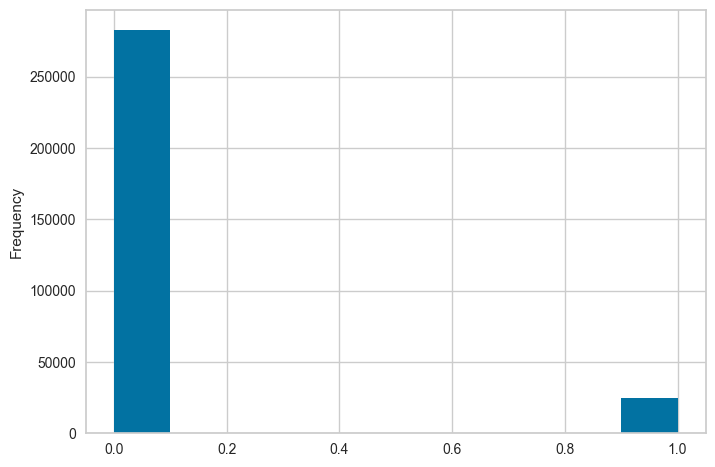

TARGET
0    0.92
1    0.08
Name: proportion, dtype: float64


In [24]:
app_train['TARGET'].plot.hist()
plt.show()

proportion_relative = app_train['TARGET'].value_counts(normalize=True)
print(proportion_relative)

Resume des features **qualitatives** : 

In [25]:
app_train.describe(exclude=[np.number])

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,307511,307511,307511,307511,306219,307511,307511,307511,307511,211120,307511,307511,97216,153214,151170,161756
unique,2,3,2,2,7,8,5,6,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,278232,202448,202924,213312,248526,158774,218391,196432,272868,55186,53901,67992,73830,150503,66040,159428


### <span style='background:purple'>f/ Autorisation d'utilisation RGPD</span>

Les données sont anonymisées, ce qui permet de les utiliser en respectant la norme RGPD. Se renseigner auprès du DPO (Data Protection Officer) pour plus de détails si nécessaire. (ce n'est pas l'objet de ce projet)

<div class="alert alert-block alert-success"><b>Bilan: </b>

Le fichier **'application_train.csv'** contient des informations sur 307_511 prêts pour 122 features. 

La feature **SK_ID_CURR** est l'identifiant du prêt.<br>
La feature **TARGET**:
- 0 si le client n'a pas eu de difficultés à rembourser son prêt (92%)<br>
- 1 si le client a eu des difficultés à rembourser son prêt (8%)<br>

Les **120 features** restantes sont des informations sur le client (âge, sexe, revenus, etc.)

Il manque 24,4% des données dans 67 features.

## <span style='background:green'>2/ application_test</span>

### <span style='background:purple'>a/ Aperçu tableau</span>

Nous affichons un apercu du début et de la fin du dataframe, ainsi que des lignes au hasard.

In [26]:
# isoler le contenu du fichier et afficher le contenu
nom_fichier = "application_test.csv"
app_test = data_brut[nom_fichier]
app_test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,5.69e+05,20560.5,4.50e+05,Unaccompanied,Working,Higher education,Married,House / apartment,1.88e-02,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.75,0.79,0.16,0.07,0.06,0.97,NaN,NaN,NaN,0.14,0.12,NaN,NaN,NaN,0.05,NaN,NaN,0.07,0.06,0.97,NaN,NaN,NaN,0.14,0.12,NaN,NaN,NaN,0.05,NaN,NaN,0.07,0.06,0.97,NaN,NaN,NaN,0.14,0.12,NaN,NaN,NaN,0.05,NaN,NaN,NaN,block of flats,0.04,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,2.23e+05,17370.0,1.80e+05,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,3.58e-02,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.56,0.29,0.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,6.63e+05,69777.0,6.30e+05,NaN,Working,Higher education,Married,House / apartment,1.91e-02,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.70,0.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1.58e+06,49018.5,1.58e+06,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,2.64e-02,-13976,-1866,-2000.0,-4208,NaN,1,1,0,1,1,

In [27]:
app_test.sample(5)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
31072,325852,Cash loans,M,Y,Y,0,135000.0,6.30e+05,32296.5,6.30e+05,Family,Working,Secondary / secondary special,Married,House / apartment,0.01,-20271,-2878,-640.0,-3831,10.0,1,1,1,1,1,0,Laborers,2.0,1,1,THURSDAY,17,0,0,0,0,0,0,Trade: type 4,NaN,0.58,0.62,0.37,0.28,0.99,0.8,0.17,0.4,0.34,0.33,0.38,0.27,0.3,0.39,3.90e-03,2.30e-03,0.38,0.3,0.99,0.8,0.17,0.4,0.34,0.33,0.38,0.28,0.33,0.41,3.90e-03,2.50e-03,0.37,0.28,0.99,0.8,0.17,0.4,0.34,0.33,0.38,0.28,0.31,0.40,3.90e-03,2.40e-03,reg oper account,block of flats,0.30,Panel,No,3.0,0.0,3.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
44536,425423,Cash loans,F,N,Y,1,112500.0,2.38e+05,25686.0,2.38e+05,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.01,-12405,-1550,-5791.0,-1078,NaN,1,1,0,1,0,0,Sales staff,3.0,2,2,FRIDAY,10,0,0,0,0,0,0,Self-employed,0.35,0.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,-864.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
25642,286684,Cash loans,F,N,Y,1,180000.0,8.49e+05,36090.0,6.75e+05,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.01,-17945,-654,-1528.0,-1478,NaN,1,1,0,1,1,1,Accountants,3.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.80,0.58,0.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-2487.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
19244,239948,Cash loans,F,Y,N,0,112500.0,2.95e+05,16141.5,2.38e+05,Unaccompanied,Pensioner,Secondary / se

Informations sur les features :
- **SK_ID_CURR** : identifiant unique du prêt

Les 120 autres features sont des informations sur le client (âge, sexe, revenus, etc.)

### <span style='background:purple'>b/ Structure</span>

In [28]:
app_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


Il y a seulement 16 features qui sont catégorielles, les autres sont numériques

### <span style='background:purple'>c/ Valeurs manquantes</span>

In [29]:
# Tableau et matrice des valeurs manquantes
valeur_manquante_text_graph(app_test, True, False)

Valeurs manquantes (Nan) : 1404419 / 5898024 données (23.81 %)
64 / 121 colonne(s) sont concernés


,Nombre de valeurs manquantes,% de valeurs manquantes
COMMONAREA_MODE,33495,68.720000
COMMONAREA_MEDI,33495,68.720000
COMMONAREA_AVG,33495,68.720000
NONLIVINGAPARTMENTS_MEDI,33347,68.410000
NONLIVINGAPARTMENTS_AVG,33347,68.410000
NONLIVINGAPARTMENTS_MODE,33347,68.410000
FONDKAPREMONT_MODE,32797,67.280000
LIVINGAPARTMENTS_MODE,32780,67.250000
LIVINGAPARTMENTS_MEDI,32780,67.250000
LIVINGAPARTMENTS_AVG,32780,67.250000


Plus de la moitié des features présentes des valeurs manquantes. Certaines features ont plus de 50% de valeurs manquantes. Au total il manque un quart des valeurs.

### <span style='background:purple'>d/ Doublons</span>

Nous vérifions qu'il n'y est ni 2 lignes doublons, ni de doublons sur la colonne SK_ID_CURR (identifiant unique du prêt).

In [30]:
app_test.duplicated().sum()

0

In [31]:
app_test.duplicated(subset=["SK_ID_CURR"]).sum()

0

Chaque identifiant est bien unique.

### <span style='background:purple'>e/ Inspection des données</span>

Résumé des features **quantitatives** :

In [32]:
app_test.describe().round(2)

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,48744.00,48744.00,4.87e+04,4.87e+04,48720.00,4.87e+04,48744.00,48744.00,48744.00,48744.00,48744.00,16432.00,48744.0,48744.00,48744.0,48744.00,48744.00,48744.00,48744.00,48744.00,48744.00,48744.00,48744.00,48744.00,48744.00,48744.00,48744.00,48744.00,28212.00,48736.00,40076.00,24857.00,21103.00,25888.00,16926.00,15249.00,23555.00,25165.00,25423.00,16278.00,20490.00,15964.00,25192.00,15397.00,22660.00,24857.00,21103.00,25888.00,16926.00,15249.00,23555.00,25165.00,25423.00,16278.00,20490.00,15964.00,25192.00,15397.00,22660.00,24857.00,21103.00,25888.00,16926.00,15249.00,23555.00,25165.00,25423.00,16278.00,20490.00,15964.00,25192.00,15397.00,22660.00,26120.00,48715.00,48715.00,48715.00,48715.0,48744.00,48744.0,48744.00,48744.00,48744.00,48744.00,48744.00,48744.00,48744.00,48744.0,48744.00,48744.0,48744.0,48744.0,48744.0,48744.0,48744.0,48744.00,48744.0,48744.0,48744.0,42695.00,42695.00,42695.00,42695.00,42695.00,42695.00
mean,277796.68,0.40,1.78e+05,5.17e+05,29426.24,4.63e+05,0.02,-16068.08,67485.37,-4967.65,-3051.71,11.79,1.0,0.81,0.2,1.00,0.26,0.16,2.15,2.04,2.01,12.01,0.02,0.06,0.04,0.08,0.22,0.17,0.50,0.52,0.50,0.12,0.09,0.98,0.75,0.05,0.09,0.15,0.23,0.24,0.07,0.11,0.11,0.01,0.03,0.12,0.09,0.98,0.76,0.05,0.08,0.15,0.23,0.23,0.07,0.11,0.11,0.01,0.03,0.12,0.09,0.98,0.75,0.05,0.08,0.15,0.23,0.24,0.07,0.11,0.11,0.01,0.03,0.11,1.45,0.14,1.44,0.1,-1077.77,0.0,0.79,0.00,0.01,0.09,0.00,0.09,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.01,0.55,1.98
std,103169.55,0.71,1.02e+05,3.65e+05,16016.37,3.37e+05,0.01,4325.90,144348.51,3552.61,1569.28,11.46,0.0,0.39,0.4,0.04,0.44,0.37,0.89,0.52,0.52,3.28,0.14,0.23,0.20,0.27,0.42,0.38,0.21,0.18,0.19,0.11,0.08,0.05,0.11,0.08,0.14,0.10,0.15,0.16,0.08,0.10,0.11,0.05,0.07,0.11,0.08,0.05,0.11,0.08,0.14,0.10,0.15,0.17,0.08,0.10,0.12,0.05,0.07,0.11,0.08,0.05,0.11,0.08,0.14,0.10,0.15,0.17,0.08,0.10,0.12,0.05,0.07,0.11,3.61,0.51,3.58,0.4,878.92,0.0,0.41,0.01,0.12,0.28,0.01,0.28,0.07,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.05,0.05,0.05,0.11,0.69,1.84
min,100001.00,0.00,2.69e+04,4.50e+04,22

Resume des features **qualitatives** : 

In [33]:
app_test.describe(exclude=[np.number])

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,48744,48744,48744,48744,47833,48744,48744,48744,48744,33139,48744,48744,15947,25125,24851,26535
unique,2,2,2,2,7,7,5,5,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,48305,32678,32311,33658,39727,24533,33988,32283,43645,8655,9751,10840,12124,24659,11269,26179


<div class="alert alert-block alert-success"><b>Bilan: </b>

Le fichier **'application_test.csv'** contient des informations sur 48_744 prêts pour 121 features. 

La feature **SK_ID_CURR** est l'identifiant du prêt.<br>
Il n'y a pas de feature TARGET.<br>
Les **120 features** restantes sont des informations sur le client (âge, sexe, revenus, etc.)

Il manque 23,8% des données dans 64 features.

## <span style='background:green'>3/ bureau</span>

### <span style='background:purple'>a/ Aperçu tableau</span>

In [34]:
nom_fichier = "bureau.csv"
bureau = data_brut[nom_fichier]
bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,9.13e+04,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,2.25e+05,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,4.64e+05,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,9.00e+04,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2.70e+06,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,1.12e+04,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,3.81e+04,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,1.56e+04,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,3.60e+04,0.0,0.0,0.0,Consumer credit,-1508,NaN


In [35]:
bureau.sample(5)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
656580,225966,6790217,Closed,currency 1,-1554,0,-612.0,-595.0,NaN,0,0.00,0.0,0.0,0.0,Credit card,-591,36787.5
991290,395284,5083130,Active,currency 1,-38,0,1058.0,NaN,0.00,0,135000.00,0.0,135000.0,0.0,Credit card,-5,NaN
671177,382238,6153448,Active,currency 1,-2373,0,877.0,NaN,NaN,0,585000.00,0.0,0.0,0.0,Credit card,-15,0.0
191107,393565,6256213,Closed,currency 1,-2424,0,-2211.0,-2181.0,7337.79,0,38274.39,0.0,0.0,0.0,Consumer credit,-2177,NaN
560565,354854,6092962,Active,currency 1,-411,0,137.0,NaN,0.00,0,80072.77,28539.0,0.0,0.0,Consumer credit,-39,NaN


Informations sur les features :
- **SK_ID_CURR** : identifiant unique du prêt
- **SK_ID_BUREAU** : identifiant des crédits précedents au prêt en cours

Les 15 autres features sont des informations sur les crédits précédents (durée, montant, etc.)

### <span style='background:purple'>b/ Structure</span>

In [36]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


Il y a seulement 3 features qui sont catégorielles, les autres sont numériques.

### <span style='background:purple'>c/ Valeurs manquantes</span>

In [37]:
valeur_manquante_text_graph(bureau, True, False)

Valeurs manquantes (Nan) : 3939947 / 29179276 données (13.5 %)
7 / 17 colonne(s) sont concernés


,Nombre de valeurs manquantes,% de valeurs manquantes
AMT_ANNUITY,1226791,71.470000
AMT_CREDIT_MAX_OVERDUE,1124488,65.510000
DAYS_ENDDATE_FACT,633653,36.920000
AMT_CREDIT_SUM_LIMIT,591780,34.480000
AMT_CREDIT_SUM_DEBT,257669,15.010000
DAYS_CREDIT_ENDDATE,105553,6.150000
AMT_CREDIT_SUM,13,0.000000


Les features **AMT_ANNUITY** et **AMT_CREDIT_MAX_OVERDUE** présentent >50% de valeurs manquantes.

### <span style='background:purple'>d/ Doublons</span>

In [38]:
bureau.duplicated().sum()

0

In [39]:
bureau.duplicated(subset=["SK_ID_CURR"]).sum()

1410617

In [40]:
df_temp = bureau[["SK_ID_CURR"]]
df_temp.nunique()

SK_ID_CURR    305811
dtype: int64

In [41]:
bureau.duplicated(subset=["SK_ID_BUREAU"]).sum()

0

L'identifiant **SK_ID_BUREAU** est bien unique, mais pas celui des crédits **SK_ID_CURR** (il y en a 305_811 qui se répètent).

### <span style='background:purple'>e/ Inspection des données</span>

Résumé des features **quantitatives** :

In [42]:
bureau.describe().round(2)

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.72e+06,1.72e+06,1.72e+06,1.72e+06,1.61e+06,1.08e+06,5.92e+05,1.72e+06,1.72e+06,1.46e+06,1.12e+06,1.72e+06,1.72e+06,4.90e+05
mean,2.78e+05,5.92e+06,-1.14e+03,8.20e-01,5.11e+02,-1.02e+03,3.83e+03,1.00e-02,3.55e+05,1.37e+05,6.23e+03,3.79e+01,-5.94e+02,1.57e+04
std,1.03e+05,5.32e+05,7.95e+02,3.65e+01,4.99e+03,7.14e+02,2.06e+05,1.00e-01,1.15e+06,6.77e+05,4.50e+04,5.94e+03,7.21e+02,3.26e+05
min,1.00e+05,5.00e+06,-2.92e+03,0.00e+00,-4.21e+04,-4.20e+04,0.00e+00,0.00e+00,0.00e+00,-4.71e+06,-5.86e+05,0.00e+00,-4.19e+04,0.00e+00
25%,1.89e+05,5.46e+06,-1.67e+03,0.00e+00,-1.14e+03,-1.49e+03,0.00e+00,0.00e+00,5.13e+04,0.00e+00,0.00e+00,0.00e+00,-9.08e+02,0.00e+00
50%,2.78e+05,5.93e+06,-9.87e+02,0.00e+00,-3.30e+02,-8.97e+02,0.00e+00,0.00e+00,1.26e+05,0.00e+00,0.00e+00,0.00e+00,-3.95e+02,0.00e+00
75%,3.67e+05,6.39e+06,-4.74e+02,0.00e+00,4.74e+02,-4.25e+02,0.00e+00,0.00e+00,3.15e+05,4.02e+04,0.00e+00,0.00e+00,-3.30e+01,1.35e+04
max,4.56e+05,6.84e+06,0.00e+00,2.79e+03,3.12e+04,0.00e+00,1.16e+08,9.00e+00,5.85e+08,1.70e+08,4.71e+06,3.76e+06,3.72e+02,1.18e+08


Resume des features **qualitatives** : 

In [43]:
bureau.describe(exclude=[np.number])

,CREDIT_ACTIVE,CREDIT_CURRENCY,CREDIT_TYPE
count,1716428,1716428,1716428
unique,4,4,15
top,Closed,currency 1,Consumer credit
freq,1079273,1715020,1251615


<div class="alert alert-block alert-success"><b>Bilan: </b>

Le fichier **'bureau.csv'** contient des informations sur 1_716_428 d'anciens crédits pour 15 features. 

La feature **SK_ID_CURR** est l'identifiant du prêt actuel (305_811 différents) et il peut être rattaché à plusieurs ancieurs anciens crédits).<br>
La feature **SK_ID_BUREAU** est l'identifiant unique des anciens crédits.<br>
Les **15 features** restantes sont des informations sur les anciens prêts (durée, montant, etc.)

Il manque 13,5% des données dans 7 features.

## <span style='background:green'>4/ bureau_balance</span>

### <span style='background:purple'>a/ Aperçu tableau</span>

In [44]:
# isoler le contenu du fichier et afficher le contenu
nom_fichier = "bureau_balance.csv"
bureau_balance = data_brut[nom_fichier]
bureau_balance

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


In [45]:
bureau_balance.sample(5)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
10007673,6415552,-6,X
12726563,5372339,-27,C
7664543,6457782,-6,C
8319919,5444854,-6,C
17424760,5258750,-80,X


Informations sur les features :
- **SK_ID_BUREAU** : identifiant des demandes de crédit
- **MONTHS_BALANCE** : Nombre de mois écoulé depuis la date de fin de remboursement prévue
- **STATUS** : statur du crédit (cloturé, retart de paiement, etc)

### <span style='background:purple'>b/ Structure</span>

In [46]:
bureau_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


Il y a seulement 1 feature qui est catégorielle, les 2 autres sont numériques.

### <span style='background:purple'>c/ Valeurs manquantes</span>

In [47]:
valeur_manquante_text_graph(bureau_balance, True, False)

Valeurs manquantes (Nan) : 0 / 81899775 données (0.0 %)
0 / 3 colonne(s) sont concernés


,Nombre de valeurs manquantes,% de valeurs manquantes


Il n'y a pas de valeurs manquantes.

### <span style='background:purple'>d/ Doublons</span>

Nous vérifions qu'il n'y est ni 2 lignes doublons, ni de doublons sur la colonne SK_ID_BUREAU (identifiant unique ...).

In [48]:
bureau_balance.duplicated().sum()

0

In [49]:
bureau_balance.duplicated(subset=["SK_ID_BUREAU"]).sum()

26482530

In [50]:
df_temp = bureau_balance[["SK_ID_BUREAU"]]
df_temp.nunique()

SK_ID_BUREAU    817395
dtype: int64

L'identifiant de demande de crédit **SK_ID_BUREAU** n'est pas unique, il est répété plusieurs fois.

### <span style='background:purple'>e/ Inspection des données</span>

Résumé des features **quantitatives** :

In [51]:
bureau_balance.describe().round(2)

,SK_ID_BUREAU,MONTHS_BALANCE
count,2.73e+07,2.73e+07
mean,6.04e+06,-3.07e+01
std,4.92e+05,2.39e+01
min,5.00e+06,-9.60e+01
25%,5.73e+06,-4.60e+01
50%,6.07e+06,-2.50e+01
75%,6.43e+06,-1.10e+01
max,6.84e+06,0.00e+00


Resume des features **qualitatives** : 

In [52]:
bureau_balance.describe(exclude=[np.number])

,STATUS
count,27299925
unique,8
top,C
freq,13646993


<div class="alert alert-block alert-success"><b>Bilan: </b>

Le fichier **'bureau_balance.csv'** contient des informations sur 817_395 anciens crédits pour 2 features. 

La feature **SK_ID_BUREAU** est l'identifiant des anciens crédit.<br>
Les **2 features** restantes sont des informations sur le statut des anciens crédits au cours des mois. 

Il n'y a aucune valeur manquante.

## <span style='background:green'>5/ credit_card_balance</span>

### <span style='background:purple'>a/ Aperçu tableau</span>

In [53]:
nom_fichier = "credit_card_balance.csv"
credit_card = data_brut[nom_fichier]
credit_card

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.97,135000,0.0,877.5,0.0,877.5,1700.33,1800.00,1800.00,0.00,0.00,0.00,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.56,45000,2250.0,2250.0,0.0,0.0,2250.00,2250.00,2250.00,60175.08,64875.56,64875.56,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.22,450000,0.0,0.0,0.0,0.0,2250.00,2250.00,2250.00,26926.42,31460.08,31460.08,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.11,225000,2250.0,2250.0,0.0,0.0,11795.76,11925.00,11925.00,224949.29,233048.97,233048.97,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.46,450000,0.0,11547.0,0.0,11547.0,22924.89,27000.00,27000.00,443044.40,453919.46,453919.46,0.0,1,0.0,1.0,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.00,45000,NaN,0.0,NaN,NaN,0.00,NaN,0.00,0.00,0.00,0.00,NaN,0,NaN,NaN,0.0,Active,0,0
3840308,1714892,347207,-9,0.00,45000,0.0,0.0,0.0,0.0,0.00,1879.11,0.00,0.00,0.00,0.00,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.97,585000,270000.0,270000.0,0.0,0.0,2250.00,375750.00,356994.67,269356.14,273093.97,273093.97,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.00,450000,NaN,0.0,NaN,NaN,0.00,NaN,0.00,0.00,0.00,0.00,NaN,0,NaN,NaN,0.0,Active,0,0


In [54]:
credit_card.sample(5)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
474801,2208084,122356,-6,0.00,0,NaN,0.00,NaN,NaN,0.00,NaN,0.00,0.00,0.00,0.00,NaN,0,NaN,NaN,0.0,Active,0,0
1433049,2313550,161828,-2,419035.28,441000,0.0,3976.65,0.0,3976.65,22979.83,22950.00,176.62,412993.98,419035.28,419035.28,0.0,3,0.0,3.0,4.0,Active,0,0
1260664,2253600,311217,-2,0.00,45000,NaN,0.00,NaN,NaN,0.00,NaN,0.00,0.00,0.00,0.00,NaN,0,NaN,NaN,0.0,Active,0,0
1200085,1523817,376945,-7,97345.89,112500,90000.0,90000.00,0.0,0.00,1460.84,1592.78,0.00,89868.06,97345.89,97345.89,1.0,1,0.0,0.0,83.0,Active,0,0
3359338,1277148,392157,-1,127391.54,135000,0.0,3887.19,0.0,3887.19,6879.38,13725.00,6975.00,125589.42,127391.54,127391.54,0.0,7,0.0,7.0,10.0,Active,0,0


Informations sur les features :
- **SK_ID_PREV** : identifiant des anciens crédits au sein de Home Credit
- **SK_ID_CURR** : identifiant unique du prêt

Les 21 autres features sont des informations sur les anciens crédits (durée, montant, etc.)

### <span style='background:purple'>b/ Structure</span>

In [55]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

Il y a seulement 1 feature qui est catégorielle, les autres sont numériques.

### <span style='background:purple'>c/ Valeurs manquantes</span>

In [56]:
valeur_manquante_text_graph(credit_card, True, False)

Valeurs manquantes (Nan) : 5877356 / 88327176 données (6.65 %)
9 / 23 colonne(s) sont concernés


,Nombre de valeurs manquantes,% de valeurs manquantes
AMT_PAYMENT_CURRENT,767988,20.000000
AMT_DRAWINGS_ATM_CURRENT,749816,19.520000
AMT_DRAWINGS_OTHER_CURRENT,749816,19.520000
AMT_DRAWINGS_POS_CURRENT,749816,19.520000
CNT_DRAWINGS_ATM_CURRENT,749816,19.520000
CNT_DRAWINGS_OTHER_CURRENT,749816,19.520000
CNT_DRAWINGS_POS_CURRENT,749816,19.520000
AMT_INST_MIN_REGULARITY,305236,7.950000
CNT_INSTALMENT_MATURE_CUM,305236,7.950000


Toutes les features ont <=20% de valeurs manquantes.

### <span style='background:purple'>d/ Doublons</span>

Nous vérifions qu'il n'y est ni 2 lignes doublons.

In [57]:
credit_card.duplicated().sum()

0

In [58]:
credit_card.duplicated(subset=["SK_ID_PREV"]).sum()

3736005

In [59]:
df_temp = credit_card[["SK_ID_PREV"]]
df_temp.nunique()

SK_ID_PREV    104307
dtype: int64

In [60]:
credit_card.duplicated(subset=["SK_ID_CURR"]).sum()

3736754

In [61]:
df_temp = credit_card[["SK_ID_CURR"]]
df_temp.nunique()

SK_ID_CURR    103558
dtype: int64

Les 2 identifiants ne sont pas uniques et sont répétés plusieurs fois. 

### <span style='background:purple'>e/ Inspection des données</span>

Résumé des features **quantitatives** :

In [62]:
credit_card.describe().round(2)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
count,3.84e+06,3.84e+06,3.84e+06,3.84e+06,3.84e+06,3.09e+06,3.84e+06,3.09e+06,3.09e+06,3.54e+06,3.07e+06,3.84e+06,3.84e+06,3.84e+06,3.84e+06,3.09e+06,3.84e+06,3.09e+06,3.09e+06,3.54e+06,3.84e+06,3.84e+06
mean,1.90e+06,2.78e+05,-3.45e+01,5.83e+04,1.54e+05,5.96e+03,7.43e+03,2.88e+02,2.97e+03,3.54e+03,1.03e+04,7.59e+03,5.60e+04,5.81e+04,5.81e+04,3.10e-01,7.00e-01,0.00e+00,5.60e-01,2.08e+01,9.28e+00,3.30e-01
std,5.36e+05,1.03e+05,2.67e+01,1.06e+05,1.65e+05,2.82e+04,3.38e+04,8.20e+03,2.08e+04,5.60e+03,3.61e+04,3.20e+04,1.03e+05,1.06e+05,1.06e+05,1.10e+00,3.19e+00,8.00e-02,3.24e+00,2.01e+01,9.75e+01,2.15e+01
min,1.00e+06,1.00e+05,-9.60e+01,-4.20e+05,0.00e+00,-6.83e+03,-6.21e+03,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,-4.23e+05,-4.20e+05,-4.20e+05,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
25%,1.43e+06,1.90e+05,-5.50e+01,0.00e+00,4.50e+04,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1.52e+02,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,4.00e+00,0.00e+00,0.00e+00
50%,1.90e+06,2.78e+05,-2.80e+01,0.00e+00,1.12e+05,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,2.70e+03,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1.50e+01,0.00e+00,0.00e+00
75%,2.37e+06,3.68e+05,-1.10e+01,8.90e+04,1.80e+05,0.00e+00,0.00e+00,0.00e+00,0.00e+00,6.63e+03,9.00e+03,6.75e+03,8.54e+04,8.89e+04,8.89e+04,0.00e+00,0.00e+00,0.00e+00,0.00e+00,3.20e+01,0.00e+00,0.00e+00
max,2.84e+06,4.56e+05,-1.00e+00,1.51e+06,1.35e+06,2.12e+06,2.29e+06,1.53e+06,2.24e+06,2.03e+05,4.29e+06,4.28e+06,1.47e+06,1.49e+06,1.49e+06,5.10e+01,1.65e+02,1.20e+01,1.65e+02,1.20e+02,3.26e+03,3.26e+03


Resume des features **qualitatives** : 

In [63]:
credit_card.describe(exclude=[np.number])

,NAME_CONTRACT_STATUS
count,3840312
unique,7
top,Active
freq,3698436


<div class="alert alert-block alert-success"><b>Bilan: </b>

Le fichier **'credit_card_balance.csv'** contient des informations sur 103_558 prêts en cours et 104_307 anciens crédit au sein de Home Credit pour 20 features. 

La feature **SK_ID_CURR** est l'identifiant du prêt.<br>
La feature **SK_ID_PREV** est l'identifiant de l'ancien crédit au sein de Home Credit.<br>
Les **20 features** restantes sont des informations sur le client (âge, sexe, revenus, etc.)

Il manque 6,7% des données dans 9 features.

## <span style='background:green'>6/ HomeCredit_columns_description</span>

### <span style='background:purple'>a/ Aperçu tableau</span>

In [64]:
nom_fichier = "HomeCredit_columns_description.csv"
homecredit_col = data_brut[nom_fichier]
homecredit_col

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
214,217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
215,218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
216,219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
217,220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN


In [65]:
homecredit_col.sample(5)

,Unnamed: 0,Table,Row,Description,Special
133,136,bureau.csv,AMT_CREDIT_SUM_DEBT,Current debt on Credit Bureau credit,NaN
187,190,previous_application.csv,RATE_INTEREST_PRIMARY,Interest rate normalized on previous credit,normalized
124,127,bureau.csv,CREDIT_ACTIVE,Status of the Credit Bureau (CB) reported credits,NaN
60,63,application_{train|test}.csv,YEARS_BEGINEXPLUATATION_MODE,Normalized information about building where th...,normalized
135,138,bureau.csv,AMT_CREDIT_SUM_OVERDUE,Current amount overdue on Credit Bureau credit,NaN


Les features sont des informations sur les features des autres fichiers du dataset. 

### <span style='background:purple'>b/ Structure</span>

In [66]:
homecredit_col.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   219 non-null    int64 
 1   Table        219 non-null    object
 2   Row          219 non-null    object
 3   Description  219 non-null    object
 4   Special      86 non-null     object
dtypes: int64(1), object(4)
memory usage: 8.7+ KB


La première feature est à supprimer, sinon ce ne sont que des features catégorielles. 

### <span style='background:purple'>c/ Valeurs manquantes</span>

In [67]:
valeur_manquante_text_graph(homecredit_col, True, False)

Valeurs manquantes (Nan) : 133 / 1095 données (12.15 %)
1 / 5 colonne(s) sont concernés


,Nombre de valeurs manquantes,% de valeurs manquantes
Special,133,60.730000


### <span style='background:purple'>d/ Doublons</span>

Nous vérifions qu'il n'y ait pas 2 lignes doublons.

In [68]:
homecredit_col.duplicated().sum()

0

### <span style='background:purple'>e/ Inspection des données</span>

Resume des features **qualitatives** : 

In [69]:
homecredit_col.describe(exclude=[np.number])

,Table,Row,Description,Special
count,219,219,219,86
unique,7,196,163,7
top,application_{train|test}.csv,SK_ID_CURR,Normalized information about building where th...,normalized
freq,122,6,47,53


<div class="alert alert-block alert-success"><b>Bilan: </b>

Le fichier **'HomeCredit_columns_description.csv'** contient des informations sur 219 features du dataset. 

Il manque 12,2% des données dans la feature "Special". La 1ère colonne est à supprimer.  

## <span style='background:green'>7/ installments_payments</span>

### <span style='background:purple'>a/ Aperçu tableau</span>

In [70]:
nom_fichier = "installments_payments.csv"
installments = data_brut[nom_fichier]
installments

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.36,6948.36
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.53,1716.53
2,2085231,193053,2.0,1,-63.0,-63.0,25425.00,25425.00
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.13,24350.13
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.04,2160.59
...,...,...,...,...,...,...,...,...
13605396,2186857,428057,0.0,66,-1624.0,NaN,67.50,NaN
13605397,1310347,414406,0.0,47,-1539.0,NaN,67.50,NaN
13605398,1308766,402199,0.0,43,-7.0,NaN,43737.43,NaN
13605399,1062206,409297,0.0,43,-1986.0,NaN,67.50,NaN


In [71]:
installments.sample(5)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
8738150,1818796,315830,0.0,23,-990.0,-990.0,218.29,218.29
5445619,1738668,245806,1.0,10,-480.0,-490.0,11883.10,11883.10
9471053,1830377,355768,2.0,6,-316.0,-324.0,31978.44,31978.44
1240567,2417562,187293,0.0,39,-2709.0,-2709.0,43200.00,43200.00
9044720,1768803,373463,1.0,3,-1860.0,-1865.0,2993.13,2993.13


Informations sur les features :
- **SK_ID_PREV** : identifiant des anciens crédits au sein de Home Credit
- **SK_ID_CURR** : identifiant unique du prêt

Les 6 autres features sont des informations sur les anciens crédits (montant, date de paiement)

### <span style='background:purple'>b/ Structure</span>

In [72]:
installments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


Toutes les features sont numériques.

### <span style='background:purple'>c/ Valeurs manquantes</span>

In [73]:
valeur_manquante_text_graph(installments, True, False)

Valeurs manquantes (Nan) : 5810 / 108843208 données (0.01 %)
2 / 8 colonne(s) sont concernés


,Nombre de valeurs manquantes,% de valeurs manquantes
DAYS_ENTRY_PAYMENT,2905,0.020000
AMT_PAYMENT,2905,0.020000


Très peu de valeurs manquantes.

### <span style='background:purple'>d/ Doublons</span>


In [74]:
installments.duplicated().sum()

0

In [75]:
installments.duplicated(subset=["SK_ID_PREV"]).sum()

12607649

In [76]:
df_temp = installments[["SK_ID_PREV"]]
df_temp.nunique()

SK_ID_PREV    997752
dtype: int64

In [77]:
installments.duplicated(subset=["SK_ID_CURR"]).sum()

13265814

In [78]:
df_temp = installments[["SK_ID_CURR"]]
df_temp.nunique()

SK_ID_CURR    339587
dtype: int64

Les 2 identifiants ne sont pas uniques et sont répétés plusieurs fois. 

### <span style='background:purple'>e/ Inspection des données</span>

Résumé des features **quantitatives** :

In [79]:
installments.describe().round(2)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.36e+07,1.36e+07,1.36e+07,1.36e+07,1.36e+07,1.36e+07,1.36e+07,1.36e+07
mean,1.90e+06,2.78e+05,8.60e-01,1.89e+01,-1.04e+03,-1.05e+03,1.71e+04,1.72e+04
std,5.36e+05,1.03e+05,1.04e+00,2.67e+01,8.01e+02,8.01e+02,5.06e+04,5.47e+04
min,1.00e+06,1.00e+05,0.00e+00,1.00e+00,-2.92e+03,-4.92e+03,0.00e+00,0.00e+00
25%,1.43e+06,1.90e+05,0.00e+00,4.00e+00,-1.65e+03,-1.66e+03,4.23e+03,3.40e+03
50%,1.90e+06,2.79e+05,1.00e+00,8.00e+00,-8.18e+02,-8.27e+02,8.88e+03,8.13e+03
75%,2.37e+06,3.68e+05,1.00e+00,1.90e+01,-3.61e+02,-3.70e+02,1.67e+04,1.61e+04
max,2.84e+06,4.56e+05,1.78e+02,2.77e+02,-1.00e+00,-1.00e+00,3.77e+06,3.77e+06


<div class="alert alert-block alert-success"><b>Bilan: </b>

Le fichier **'installments_payments.csv'** contient des informations sur 339_587 prêts et 997_752 anciens crédits pour 6 features. 

La feature **SK_ID_CURR** est l'identifiant du prêt.<br>
La feature **SK_ID_PREV** est l'identifiant de l'ancien crédit.<br>
Les **6 features** restantes sont des informations de modalité de paiement des anciens crédits. 

Il manque 0,01% des données dans 2 features.

## <span style='background:green'>8/ POS_CASH_balance</span>

### <span style='background:purple'>a/ Aperçu tableau</span>

In [80]:
nom_fichier = "POS_CASH_balance.csv"
pos_cash = data_brut[nom_fichier]
pos_cash

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0


In [81]:
pos_cash.sample(5)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
737632,1430066,132521,-7,18.0,7.0,Active,0,0
7956570,1839158,436592,-58,10.0,5.0,Active,0,0
5606313,2552957,189169,-22,48.0,47.0,Active,0,0
2438258,1820099,220224,-14,18.0,1.0,Active,0,0
4727266,1256877,283500,-58,8.0,5.0,Active,0,0


Informations sur les features :
- **SK_ID_PREV** : identifiant des anciens crédits au sein de Home Credit
- **SK_ID_CURR** : identifiant unique du prêt

Les 6 autres features sont des informations sur les anciens crédits (montant, date de paiement)

### <span style='background:purple'>b/ Structure</span>

In [82]:
pos_cash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


Il y a une seule feature catégorielle, les autres sont numériques.

### <span style='background:purple'>c/ Valeurs manquantes</span>

In [83]:
valeur_manquante_text_graph(pos_cash, True, False)

Valeurs manquantes (Nan) : 52158 / 80010864 données (0.07 %)
2 / 8 colonne(s) sont concernés


,Nombre de valeurs manquantes,% de valeurs manquantes
CNT_INSTALMENT,26071,0.260000
CNT_INSTALMENT_FUTURE,26087,0.260000


Il manque très peu de valeurs.

### <span style='background:purple'>d/ Doublons</span>

In [84]:
pos_cash.duplicated().sum()

0

In [85]:
pos_cash.duplicated(subset=["SK_ID_PREV"]).sum()

9065033

In [86]:
df_temp = pos_cash[["SK_ID_PREV"]]
df_temp.nunique()

SK_ID_PREV    936325
dtype: int64

In [87]:
pos_cash.duplicated(subset=["SK_ID_CURR"]).sum()

9664106

In [88]:
df_temp = pos_cash[["SK_ID_CURR"]]
df_temp.nunique()

SK_ID_CURR    337252
dtype: int64

Les 2 identifiants ne sont pas uniques et sont répétés plusieurs fois. 

### <span style='background:purple'>e/ Inspection des données</span>

Résumé des features **quantitatives** :

In [89]:
pos_cash.describe().round(2)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
count,1.00e+07,1.00e+07,1.00e+07,9.98e+06,9.98e+06,1.00e+07,1.00e+07
mean,1.90e+06,2.78e+05,-3.50e+01,1.71e+01,1.05e+01,1.16e+01,6.50e-01
std,5.36e+05,1.03e+05,2.61e+01,1.20e+01,1.11e+01,1.33e+02,3.28e+01
min,1.00e+06,1.00e+05,-9.60e+01,1.00e+00,0.00e+00,0.00e+00,0.00e+00
25%,1.43e+06,1.90e+05,-5.40e+01,1.00e+01,3.00e+00,0.00e+00,0.00e+00
50%,1.90e+06,2.79e+05,-2.80e+01,1.20e+01,7.00e+00,0.00e+00,0.00e+00
75%,2.37e+06,3.67e+05,-1.30e+01,2.40e+01,1.40e+01,0.00e+00,0.00e+00
max,2.84e+06,4.56e+05,-1.00e+00,9.20e+01,8.50e+01,4.23e+03,3.60e+03


Resume des features **qualitatives** : 

In [90]:
pos_cash.describe(exclude=[np.number])

,NAME_CONTRACT_STATUS
count,10001358
unique,9
top,Active
freq,9151119


<div class="alert alert-block alert-success"><b>Bilan: </b>

Le fichier **'POS_CASH_balance.csv'** contient des informations sur 337_252 prêts et 936_325 anciens crédit pour 6 features. 

La feature **SK_ID_CURR** est l'identifiant du prêt.<br>
La feature **SK_ID_PREV** est l'identifiant de l'ancien crédit.<br>
Les **6 features** restantes sont des informations de modalité de paiement des anciens crédits. 

Il manque 0,07% des données dans 2 features.

## <span style='background:green'>9/ previous_application</span>

### <span style='background:purple'>a/ Aperçu tableau</span>

In [91]:
nom_fichier = "previous_application.csv"
previous_app = data_brut[nom_fichier]
previous_app

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.43,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.00,0.18,0.87,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.62,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.74,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.33,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.40,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.29,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,Y,1,0.00,NaN,NaN,XAP,Approved,-544,Cash through the bank,XAP,NaN,Refreshed,Furniture,POS,XNA,Stone,43,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,Consumer loans,6622.02,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,Y,1,0.34,NaN,NaN,XAP,Approved,-1694,Cash through the bank,XAP,Unaccompanied,New,Furniture,POS,XNA,Stone,43,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0
1670211,2659632,249544,Consumer loans,11520.85,105237.0,102523.5,10525.5,105237.0,MONDAY,12,Y,1,0.10,NaN,NaN,XAP,Approved,-1488,Cash through the bank,XAP,"Spouse, partner",Repeater,Consumer Electronics,POS,XNA,Country-wide,1370,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0
1670212,2785582,400317,Cash loans,18821.52,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,Y,1,NaN,NaN,NaN,XNA,Approved,-1185,Cash through the bank,XAP,Family,Repeater,XNA,Cash,x-sell,AP+ (Cash loan),-1,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0


In [92]:
previous_app.sample(5)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
1489881,2786374,399937,Cash loans,NaN,0.0,0.0,NaN,NaN,SATURDAY,12,Y,1,NaN,NaN,NaN,XNA,Canceled,-10,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Contact center,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1105445,1777953,191866,Consumer loans,NaN,24373.8,24373.8,0.0,24373.8,WEDNESDAY,13,Y,1,0.0,NaN,NaN,XAP,Unused offer,-1044,Cash through the bank,CLIENT,NaN,Repeater,Photo / Cinema Equipment,XNA,XNA,Country-wide,65,Connectivity,NaN,XNA,POS mobile with interest,NaN,NaN,NaN,NaN,NaN,NaN
1352548,2509984,317866,Consumer loans,7010.1,36400.5,34380.0,3640.5,36400.5,SUNDAY,15,Y,1,0.1,NaN,NaN,XAP,Approved,-2137,Cash through the bank,XAP,NaN,New,Photo / Cinema Equipment,POS,XNA,Country-wide,48,Connectivity,6.0,high,POS mobile with interest,365243.0,-2105.0,-1955.0,-1955.0,-1948.0,0.0
1176223,1360360,233604,Revolving loans,38250.0,765000.0,765000.0,NaN,765000.0,SATURDAY,14,Y,1,NaN,NaN,NaN,XAP,Approved,-458,XNA,XAP,Unaccompanied,Repeater,XNA,Cards,x-sell,Credit and cash offices,-1,XNA,0.0,XNA,Card X-Sell,-398.0,-358.0,365243.0,365243.0,365243.0,0.0
1125922,1875883,427194,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,18,Y,1,NaN,NaN,NaN,XNA,Canceled,-278,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN


Informations sur les features :
- **SK_ID_PREV** : identifiant des anciens crédits au sein de Home Credit
- **SK_ID_CURR** : identifiant unique du prêt

Les 35 autres features sont des informations sur les anciens crédits (montant, date de paiement)

### <span style='background:purple'>b/ Structure</span>

In [93]:
previous_app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

Il y a 16 features catégorielles, les autres sont numériques.

### <span style='background:purple'>c/ Valeurs manquantes</span>

In [94]:
valeur_manquante_text_graph(previous_app, True, False)

Valeurs manquantes (Nan) : 11109336 / 61797918 données (17.98 %)
16 / 37 colonne(s) sont concernés


,Nombre de valeurs manquantes,% de valeurs manquantes
RATE_INTEREST_PRIMARY,1664263,99.640000
RATE_INTEREST_PRIVILEGED,1664263,99.640000
AMT_DOWN_PAYMENT,895844,53.640000
RATE_DOWN_PAYMENT,895844,53.640000
NAME_TYPE_SUITE,820405,49.120000
DAYS_FIRST_DRAWING,673065,40.300000
DAYS_FIRST_DUE,673065,40.300000
DAYS_LAST_DUE_1ST_VERSION,673065,40.300000
DAYS_LAST_DUE,673065,40.300000
DAYS_TERMINATION,673065,40.300000


Il y a 2 features qui sont quasiment vides, 9 autres qui présentent >40% de valeurs manquantes, 3 features qui présentent <25% de valeurs manquantes et 2 features qui ne présentent que quelques valeurs manquantes.

### <span style='background:purple'>d/ Doublons</span>


In [95]:
previous_app.duplicated().sum()

0

In [96]:
previous_app.duplicated(subset=["SK_ID_PREV"]).sum()

0

In [97]:
previous_app.duplicated(subset=["SK_ID_CURR"]).sum()

1331357

In [98]:
df_temp = previous_app[["SK_ID_CURR"]]
df_temp.nunique()

SK_ID_CURR    338857
dtype: int64

Seul l'identifiant **SK_ID_PREV** des anciens crédit est unique.

### <span style='background:purple'>e/ Inspection des données</span>

Résumé des features **quantitatives** :

In [99]:
previous_app.describe().round(2)

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.67e+06,1.67e+06,1.30e+06,1.67e+06,1.67e+06,7.74e+05,1.28e+06,1.67e+06,1.67e+06,774370.00,5951.00,5951.00,1.67e+06,1.67e+06,1.30e+06,997149.00,997149.00,997149.00,997149.00,997149.00,997149.00
mean,1.92e+06,2.78e+05,1.60e+04,1.75e+05,1.96e+05,6.70e+03,2.28e+05,1.25e+01,1.00e+00,0.08,0.19,0.77,-8.81e+02,3.14e+02,1.61e+01,342209.86,13826.27,33767.77,76582.40,81992.34,0.33
std,5.33e+05,1.03e+05,1.48e+04,2.93e+05,3.19e+05,2.09e+04,3.15e+05,3.33e+00,6.00e-02,0.11,0.09,0.10,7.79e+02,7.13e+03,1.46e+01,88916.12,72444.87,106857.03,149647.42,153303.52,0.47
min,1.00e+06,1.00e+05,0.00e+00,0.00e+00,0.00e+00,-9.00e-01,0.00e+00,0.00e+00,0.00e+00,-0.00,0.03,0.37,-2.92e+03,-1.00e+00,0.00e+00,-2922.00,-2892.00,-2801.00,-2889.00,-2874.00,0.00
25%,1.46e+06,1.89e+05,6.32e+03,1.87e+04,2.42e+04,0.00e+00,5.08e+04,1.00e+01,1.00e+00,0.00,0.16,0.72,-1.30e+03,-1.00e+00,6.00e+00,365243.00,-1628.00,-1242.00,-1314.00,-1270.00,0.00
50%,1.92e+06,2.79e+05,1.12e+04,7.10e+04,8.05e+04,1.64e+03,1.12e+05,1.20e+01,1.00e+00,0.05,0.19,0.84,-5.81e+02,3.00e+00,1.20e+01,365243.00,-831.00,-361.00,-537.00,-499.00,0.00
75%,2.38e+06,3.68e+05,2.07e+04,1.80e+05,2.16e+05,7.74e+03,2.34e+05,1.50e+01,1.00e+00,0.11,0.19,0.85,-2.80e+02,8.20e+01,2.40e+01,365243.00,-411.00,129.00,-74.00,-44.00,1.00
max,2.85e+06,4.56e+05,4.18e+05,6.91e+06,6.91e+06,3.06e+06,6.91e+06,2.30e+01,1.00e+00,1.00,1.00,1.00,-1.00e+00,4.00e+06,8.40e+01,365243.00,365243.00,365243.00,365243.00,365243.00,1.00


Resume des features **qualitatives** : 

In [100]:
previous_app.describe(exclude=[np.number])

,NAME_CONTRACT_TYPE,WEEKDAY_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION
count,1670214,1670214,1670214,1670214,1670214,1670214,1670214,849809,1670214,1670214,1670214,1670214,1670214,1670214,1670214,1669868
unique,4,7,2,25,4,4,9,7,4,28,5,3,8,11,5,17
top,Cash loans,TUESDAY,Y,XAP,Approved,Cash through the bank,XAP,Unaccompanied,Repeater,XNA,POS,XNA,Credit and cash offices,XNA,XNA,Cash
freq,747553,255118,1661739,922661,1036781,1033552,1353093,508970,1231261,950809,691011,1063666,719968,855720,517215,285990


<div class="alert alert-block alert-success"><b>Bilan: </b>

Le fichier **'previous_application.csv'** contient des informations sur 338_857 prêts et 1_670_214 anciens crédit pour 35 features. 

La feature **SK_ID_CURR** est l'identifiant du prêt.<br>
La feature **SK_ID_PREV** est l'identifiant de l'ancien crédit.<br>
Les **35 features** restantes sont des informations sur les anciens crédits. 

Il manque 18,0% des données dans 16 features.

## <span style='background:green'>10/ sample_submission</span>

### <span style='background:purple'>a/ Aperçu tableau</span>

In [101]:
nom_fichier = "sample_submission.csv"
sample_sub = data_brut[nom_fichier]
sample_sub

,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5
3,100028,0.5
4,100038,0.5
...,...,...
48739,456221,0.5
48740,456222,0.5
48741,456223,0.5
48742,456224,0.5


In [102]:
sample_sub.sample(5)

,SK_ID_CURR,TARGET
39758,392809,0.5
9223,167182,0.5
15751,213546,0.5
21847,258560,0.5
25246,283736,0.5


Informations sur les features :
- **SK_ID_CURR** : identifiant unique du prêt
- **TARGET** : variable cible

### <span style='background:purple'>b/ Structure</span>

In [103]:
sample_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SK_ID_CURR  48744 non-null  int64  
 1   TARGET      48744 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 761.8 KB


Il n'y a que des variables numériques.

### <span style='background:purple'>c/ Valeurs manquantes</span>

In [104]:
valeur_manquante_text_graph(sample_sub, True, False)

Valeurs manquantes (Nan) : 0 / 97488 données (0.0 %)
0 / 2 colonne(s) sont concernés


,Nombre de valeurs manquantes,% de valeurs manquantes


Il n'y a pas de valeurs manquantes.

### <span style='background:purple'>d/ Doublons</span>


In [105]:
sample_sub.duplicated().sum()

0

In [106]:
sample_sub.duplicated(subset=["SK_ID_CURR"]).sum()

0

L'identifiant **SK_ID_CURR** des prêts est unique.

### <span style='background:purple'>e/ Inspection des données</span>

Résumé des features **quantitatives** :

In [107]:
sample_sub.describe().round(2)

,SK_ID_CURR,TARGET
count,48744.00,48744.0
mean,277796.68,0.5
std,103169.55,0.0
min,100001.00,0.5
25%,188557.75,0.5
50%,277549.00,0.5
75%,367555.50,0.5
max,456250.00,0.5


<div class="alert alert-block alert-success"><b>Bilan: </b>

Le fichier **'sample_submission.csv'** contient des informations sur 48_743 prêts. 

La feature **SK_ID_CURR** est l'identifiant du prêt.<br>
La feature **TARGET** est la variable cible, ce ne sont que des 0,5.

Il ne manque aucune donnée.

# <span style='background:blue'>Etape 2 : Feature engineering et jointure</span>

## <span style='background:green'>1/ Application_train/test</span>

### <span style='background:purple'>a/ Aperçu valeurs abérantes</span>

**CODE_GENDER**

Nous observons des valeurs uniques dans la feature 'CODE_GENDER'

In [19]:
print(app_train['CODE_GENDER'].value_counts())

CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64


Nous remarquons qu'il y a des erreurs puisque le 'CODE_GENDER' comporte la valeur 'XNA' alors qu'il ne peut être que 'F' ou 'M'. 

*Nous allons supprimer ces 4 erreurs.*

**DAYS_EMPLOYED**

Nous observons également des valeurs abérantes dans la feature 'DAYS_EMPLOYED'

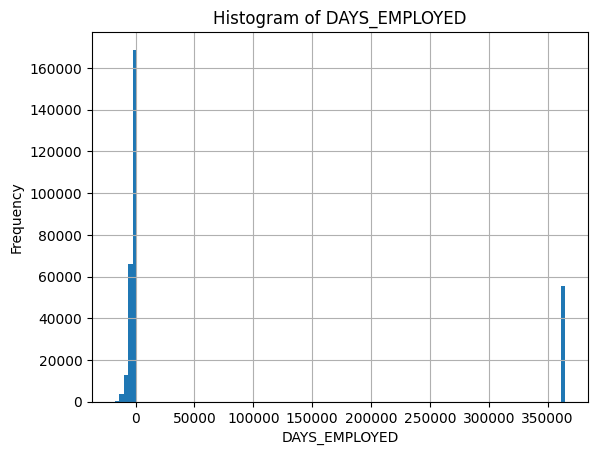

In [20]:
app_train['DAYS_EMPLOYED'].hist(bins=100)
plt.title('Histogram of DAYS_EMPLOYED')
plt.xlabel('DAYS_EMPLOYED')
plt.ylabel('Frequency')
plt.show()

In [21]:
print(app_train['DAYS_EMPLOYED'].value_counts())

DAYS_EMPLOYED
 365243    55374
-200         156
-224         152
-230         151
-199         151
           ...  
-13961         1
-11827         1
-10176         1
-9459          1
-8694          1
Name: count, Length: 12574, dtype: int64


Alors que toutes les valeurs sont négatives, nous observons un groupe de valeur positives et très élevées. En effet, il ya 55_374 fois la valeur 365_243 jours. Ce qui correspond à 1_000 ans (365_243 / 365,24).

*Cette valeur est donc abérante et à remplacer par des NaN.*

### <span style='background:purple'>b/ Application data engineering</span>

Nous réalisons le feature engineering suivant :
- Concaténation des 2 datasets
- Suppression des lignes avec valeurs abérantes de CODE_GENDER
- Encodage des variables catégorielles :
  - LabelEncoder si <=2 valeurs uniques
  - OneHotEncoder si >2 valeurs uniques
- Suppression des valeurs abérantes de DAYS_EMPLOYED
- Création de nouvelles features :
  - 'DAY_EMPLOYED_PERC' : proportion de jours travaillés par rapport à l'âge
  - 'INCOME_CREDIT_PERC' : proportion de revenus par rapport au montant du crédit
  - 'INCOME_PER_PERSON' : revenus par personne dans la famille
  - 'ANNUITY_INCOME_PERC' : proportion de l'annuité par rapport aux revenus
  - 'PAYMENT_RATE' : taux de remboursement

In [22]:
df_merged = feature_engin_application_train_test(app_train, app_test)

4 feature(s) ont subie(s) le LabelEncoder:
NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY

Nombre de nouvelles features avec One-Hot : 131
NAME_TYPE_SUITE_Children
NAME_TYPE_SUITE_Family
NAME_TYPE_SUITE_Group of people
NAME_TYPE_SUITE_Other_A
NAME_TYPE_SUITE_Other_B
NAME_TYPE_SUITE_Spouse partner
NAME_TYPE_SUITE_Unaccompanied
NAME_INCOME_TYPE_Businessman
NAME_INCOME_TYPE_Commercial associate
NAME_INCOME_TYPE_Maternity leave
NAME_INCOME_TYPE_Pensioner
NAME_INCOME_TYPE_State servant
NAME_INCOME_TYPE_Student
NAME_INCOME_TYPE_Unemployed
NAME_INCOME_TYPE_Working
NAME_EDUCATION_TYPE_Academic degree
NAME_EDUCATION_TYPE_Higher education
NAME_EDUCATION_TYPE_Incomplete higher
NAME_EDUCATION_TYPE_Lower secondary
NAME_EDUCATION_TYPE_Secondary secondary special
NAME_FAMILY_STATUS_Civil marriage
NAME_FAMILY_STATUS_Married
NAME_FAMILY_STATUS_Separated
NAME_FAMILY_STATUS_Single not married
NAME_FAMILY_STATUS_Unknown
NAME_FAMILY_STATUS_Widow
NAME_HOUSING_TYPE_Co op apartment
NAME_HOUSING_T

In [23]:
display(df_merged)

,index,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,...,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry type 1,ORGANIZATION_TYPE_Industry type 10,ORGANIZATION_TYPE_Industry type 11,ORGANIZATION_TYPE_Industry type 12,ORGANIZATION_TYPE_Industry type 13,ORGANIZATION_TYPE_Industry type 2,ORGANIZATION_TYPE_Industry type 3,ORGANIZATION_TYPE_Industry type 4,ORGANIZATION_TYPE_Industry type 5,ORGANIZATION_TYPE_Industry type 6,ORGANIZATION_TYPE_Industry type 7,ORGANIZATION_TYPE_Industry type 8,ORGANIZATION_TYPE_Industry type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade type 1,ORGANIZATION_TYPE_Trade type 2,ORGANIZATION_TYPE_Trade type 3,ORGANIZATION_TYPE_Trade type 4,ORGANIZATION_TYPE_Trade type 5,ORGANIZATION_TYPE_Trade type 6,ORGANIZATION_TYPE_Trade type 7,ORGANIZATION_TYPE_Transport type 1,ORGANIZATION_TYPE_Transport type 2,ORGANIZATION_TYPE_Transport type 3,ORGANIZATION_TYPE_Transport type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stone brick,WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0,100002,1.0,0,1,0,1,0,202500.0,4.07e+05,24700.5,3.51e+05,1.88e-02,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00e+00,0.00e+00,0.03,0.04,0.97,0.63,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.0,0.00,0.03,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,...,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

## <span style='background:green'>2/ bureau & bureau_balance</span>

Nous réalisons le feature engineering suivant :

- Encodage des variables catégorielles :
  - LabelEncoder si <=2 valeurs uniques
  - OneHotEncoder si >2 valeurs uniques

- Aggrégation des données de bureau_balance par **SK_ID_BUREAU**
  - MONTHS_BALANCE : min, max, size
  - Features One_hot_encoded : mean

- Jointure (left) de bureau et bureau_balance aggrégé sur **SK_ID_BUREAU**

- Aggrégation des données de bureau_aggregées par **SK_ID_CURR**
  - features numériques : min, max, mean, var, sum (selon la feature)
  - features catégorielles : mean

- Aggrégation de bureau_aggregées par **SK_ID_CURR** pour les crédits actifs

- Aggrégation de bureau_aggregées par **SK_ID_CURR** pour les crédits cloturés

- Jointure (left) de bureau_aggregées et les 3 aggrégations précédentes sur **SK_ID_CURR**

In [25]:
bureau = feature_engin_bureau_balance(bureau, bureau_balance)

0 feature(s) ont subie(s) le LabelEncoder:

Nombre de nouvelles features avec One-Hot : 23
CREDIT_ACTIVE_Active
CREDIT_ACTIVE_Bad debt
CREDIT_ACTIVE_Closed
CREDIT_ACTIVE_Sold
CREDIT_CURRENCY_currency 1
CREDIT_CURRENCY_currency 2
CREDIT_CURRENCY_currency 3
CREDIT_CURRENCY_currency 4
CREDIT_TYPE_Another type of loan
CREDIT_TYPE_Car loan
CREDIT_TYPE_Cash loan non earmarked 
CREDIT_TYPE_Consumer credit
CREDIT_TYPE_Credit card
CREDIT_TYPE_Interbank credit
CREDIT_TYPE_Loan for business development
CREDIT_TYPE_Loan for purchase of shares margin lending 
CREDIT_TYPE_Loan for the purchase of equipment
CREDIT_TYPE_Loan for working capital replenishment
CREDIT_TYPE_Microloan
CREDIT_TYPE_Mobile operator loan
CREDIT_TYPE_Mortgage
CREDIT_TYPE_Real estate loan
CREDIT_TYPE_Unknown type of loan
--------------------------------------------------
0 feature(s) ont subie(s) le LabelEncoder:

Nombre de nouvelles features avec One-Hot : 8
STATUS_0
STATUS_1
STATUS_2
STATUS_3
STATUS_4
STATUS_5
STATUS_C
STATUS_

In [26]:
print("Dimensions bureau:", bureau.shape)

Dimensions bureau: (305811, 112)


Nous ajoutons ce dataframe au dataframe principal.

In [27]:
df_merged = df_merged.join(bureau, how='left', on='SK_ID_CURR')
display(df_merged)

# Suppression variable pour libérer de la mémoire
del bureau

,index,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,...,BURO_CREDIT_TYPE_Cash loan non earmarked _MEAN,BURO_CREDIT_TYPE_Consumer credit_MEAN,BURO_CREDIT_TYPE_Credit card_MEAN,BURO_CREDIT_TYPE_Interbank credit_MEAN,BURO_CREDIT_TYPE_Loan for business development_MEAN,BURO_CREDIT_TYPE_Loan for purchase of shares margin lending _MEAN,BURO_CREDIT_TYPE_Loan for the purchase of equipment_MEAN,BURO_CREDIT_TYPE_Loan for working capital replenishment_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,BURO_CREDIT_TYPE_Mobile operator loan_MEAN,BURO_CREDIT_TYPE_Mortgage_MEAN,BURO_CREDIT_TYPE_Real estate loan_MEAN,BURO_CREDIT_TYPE_Unknown type of loan_MEAN,BURO_STATUS_0_MEAN_MEAN,BURO_STATUS_1_MEAN_MEAN,BURO_STATUS_2_MEAN_MEAN,BURO_STATUS_3_MEAN_MEAN,BURO_STATUS_4_MEAN_MEAN,BURO_STATUS_5_MEAN_MEAN,BURO_STATUS_C_MEAN_MEAN,BURO_STATUS_X_MEAN_MEAN,ACTIVE_DAYS_CREDIT_MIN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_VAR,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,ACTIVE_CREDIT_DAY_OVERDUE_MAX,ACTIVE_CREDIT_DAY_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_SUM_MAX,ACTIVE_AMT_CREDIT_SUM_MEAN,ACTIVE_AMT_CREDIT_SUM_SUM,ACTIVE_AMT_CREDIT_SUM_DEBT_MAX,ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,ACTIVE_AMT_CREDIT_SUM_DEBT_SUM,ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN,ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM,ACTIVE_AMT_ANNUITY_MAX,ACTIVE_AMT_ANNUITY_MEAN,ACTIVE_CNT_CREDIT_PROLONG_SUM,ACTIVE_MONTHS_BALANCE_MIN_MIN,ACTIVE_MONTHS_BALANCE_MAX_MAX,ACTIVE_MONTHS_BALANCE_SIZE_MEAN,ACTIVE_MONTHS_BALANCE_SIZE_SUM,CLOSED_DAYS_CREDIT_MIN,CLOSED_DAYS_CREDIT_MAX,CLOSED_DAYS_CREDIT_MEAN,CLOSED_DAYS_CREDIT_VAR,CLOSED_DAYS_CREDIT_ENDDATE_MIN,CLOSED_DAYS_CREDIT_ENDDATE_MAX,CLOSED_DAYS_CREDIT_ENDDATE_MEAN,CLOSED_DAYS_CREDIT_UPDATE_MEAN,CLOSED_CREDIT_DAY_OVERDUE_MAX,CLOSED_CREDIT_DAY_OVERDUE_MEAN,CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_MAX,CLOSED_AMT_CREDIT_SUM_MEAN,CLOSED_AMT_CREDIT_SUM_SUM,CLOSED_AMT_CREDIT_SUM_DEBT_MAX,CLOSED_AMT_CREDIT_SUM_DEBT_MEAN,CLOSED_AMT_CREDIT_SUM_DEBT_SUM,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_MAX,CLOSED_AMT_ANNUITY_MEAN,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_MIN_MIN,CLOSED_MONTHS_BALANCE_MAX_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,CLOSED_MONTHS_BALANCE_SIZE_SUM
0,0,100002,1.0,0,1,0,1,0,202500.0,4.07e+05,24700.5,3.51e+05,1.88e-02,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00e+00,0.00e+00,0.03,0.04,0.97,0.63,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.0,0.00,0.03,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,...,0.0,0.50,0.50,0.0,0.0,0.

## <span style='background:green'>3/ credit_card_balance</span>

Nous réalisons le feature engineering suivant :

- Encodage des variables catégorielles :
  - LabelEncoder si <=2 valeurs uniques
  - OneHotEncoder si >2 valeurs uniques

- Suppression de la feature 'SK_ID_PREV'

- Aggrégation des données de credit_card_balance par **SK_ID_CURR**
  - Toutes features : min, max, mean, sum, var

- Création de nouvelles features :
  - 'CC_COUNT' : nombre de ligne par **SK_ID_CURR**

In [29]:
credit_card = feature_engin_credit_card_balance(credit_card)

0 feature(s) ont subie(s) le LabelEncoder:

Nombre de nouvelles features avec One-Hot : 7
NAME_CONTRACT_STATUS_Active
NAME_CONTRACT_STATUS_Approved
NAME_CONTRACT_STATUS_Completed
NAME_CONTRACT_STATUS_Demand
NAME_CONTRACT_STATUS_Refused
NAME_CONTRACT_STATUS_Sent proposal
NAME_CONTRACT_STATUS_Signed


In [30]:
print("Dimensions credit_card:", credit_card.shape)

Dimensions credit_card: (103558, 136)


Nous ajoutons ce dataframe au dataframe principal.

In [31]:
df_merged = df_merged.join(credit_card, how='left', on='SK_ID_CURR')
display(df_merged)

# Suppression variable pour libérer de la mémoire
del credit_card

,index,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,...,CC_AMT_TOTAL_RECEIVABLE_MAX,CC_AMT_TOTAL_RECEIVABLE_MEAN,CC_AMT_TOTAL_RECEIVABLE_SUM,CC_AMT_TOTAL_RECEIVABLE_VAR,CC_CNT_DRAWINGS_ATM_CURRENT_MIN,CC_CNT_DRAWINGS_ATM_CURRENT_MAX,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,CC_CNT_DRAWINGS_CURRENT_MIN,CC_CNT_DRAWINGS_CURRENT_MAX,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_SUM,CC_CNT_DRAWINGS_CURRENT_VAR,CC_CNT_DRAWINGS_OTHER_CURRENT_MIN,CC_CNT_DRAWINGS_OTHER_CURRENT_MAX,CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN,CC_CNT_DRAWINGS_OTHER_CURRENT_SUM,CC_CNT_DRAWINGS_OTHER_CURRENT_VAR,CC_CNT_DRAWINGS_POS_CURRENT_MIN,CC_CNT_DRAWINGS_POS_CURRENT_MAX,CC_CNT_DRAWINGS_POS_CURRENT_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_DRAWINGS_POS_CURRENT_VAR,CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_CNT_INSTALMENT_MATURE_CUM_MAX,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CNT_INSTALMENT_MATURE_CUM_VAR,CC_SK_DPD_MIN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Approved_MIN,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Approved_SUM,CC_NAME_CONTRACT_STATUS_Approved_VAR,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Demand_SUM,CC_NAME_CONTRACT_STATUS_Demand_VAR,CC_NAME_CONTRACT_STATUS_Refused_MIN,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Refused_SUM,CC_NAME_CONTRACT_STATUS_Refused_VAR,CC_NAME_CONTRACT_STATUS_Sent proposal_MIN,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_COUNT
0,0,100002,1.0,0,1,0,1,0,202500.0,4.07e+05,24700.5,3.51e+05,1.88e-02,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00e+00,0.00e+00,0.03,0.04,0.97,0.63,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.0,0.00,0.03,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,

## <span style='background:green'>4/ installments_payments</span>

Nous réalisons le feature engineering suivant :

- Création de nouvelles features :
  - 'PAYMENT_PERC' : proportion du montant payé par rapport au montant attendu
  - 'PAYMENT_DIFF' : différence entre le montant payé et le montant attendu
  - 'DPD' : nombre de jours de retard de paiement
  - 'DBD' : nombre de jours d'avance de paiement

- Aggrégation des données de installments_payments par **SK_ID_CURR**
    - features numériques : nunique, min, max, mean, var, sum (selon la feature)

- Création de nouvelles features :
  - 'INSTAL_COUNT' : nombre de ligne par **SK_ID_CURR**

In [33]:
installments = feature_engin_credit_installments_payments(installments)

In [34]:
print("Dimensions installments:", installments.shape)

Dimensions installments: (339587, 26)


Nous ajoutons ce dataframe au dataframe principal.

In [35]:
df_merged = df_merged.join(installments, how='left', on='SK_ID_CURR')
display(df_merged)

# Suppression variable pour libérer de la mémoire
del installments

,index,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,...,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CNT_INSTALMENT_MATURE_CUM_VAR,CC_SK_DPD_MIN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Approved_MIN,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Approved_SUM,CC_NAME_CONTRACT_STATUS_Approved_VAR,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Demand_SUM,CC_NAME_CONTRACT_STATUS_Demand_VAR,CC_NAME_CONTRACT_STATUS_Refused_MIN,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Refused_SUM,CC_NAME_CONTRACT_STATUS_Refused_VAR,CC_NAME_CONTRACT_STATUS_Sent proposal_MIN,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_COUNT,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_PERC_VAR,INSTAL_PAYMENT_DIFF_MAX,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_COUNT
0,0,100002,1.0,0,1,0,1,0,202500.0,4.07e+05,24700.5,3.51e+05,1.88e-02,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00e+00,0.00e+00,0.03,0.04,0.97,0.63,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.0,0.00,0.03,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,-49.

## <span style='background:green'>5/ POS_CASH_balance</span>

Nous réalisons le feature engineering suivant :

- Encodage des variables catégorielles :
  - LabelEncoder si <=2 valeurs uniques
  - OneHotEncoder si >2 valeurs uniques

- Aggrégation des données de POS_CASH_balance par **SK_ID_CURR**
  - features numériques : max, mean, size (selon la feature)
  - features catégorielles : mean

- Création de nouvelles features :
  - 'POS_COUNT' : nombre de ligne par **SK_ID_CURR**

In [37]:
pos_cash = feature_engin_pos_cash_balance(pos_cash)

0 feature(s) ont subie(s) le LabelEncoder:

Nombre de nouvelles features avec One-Hot : 9
NAME_CONTRACT_STATUS_Active
NAME_CONTRACT_STATUS_Amortized debt
NAME_CONTRACT_STATUS_Approved
NAME_CONTRACT_STATUS_Canceled
NAME_CONTRACT_STATUS_Completed
NAME_CONTRACT_STATUS_Demand
NAME_CONTRACT_STATUS_Returned to the store
NAME_CONTRACT_STATUS_Signed
NAME_CONTRACT_STATUS_XNA


In [38]:
print("Dimensions pos_cash:", pos_cash.shape)

Dimensions pos_cash: (337252, 17)


Nous ajoutons ce dataframe au dataframe principal.

In [39]:
df_merged = df_merged.join(pos_cash, how='left', on='SK_ID_CURR')
display(df_merged)

# Suppression variable pour libérer de la mémoire
del pos_cash

,index,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,...,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Approved_MIN,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Approved_SUM,CC_NAME_CONTRACT_STATUS_Approved_VAR,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Demand_SUM,CC_NAME_CONTRACT_STATUS_Demand_VAR,CC_NAME_CONTRACT_STATUS_Refused_MIN,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Refused_SUM,CC_NAME_CONTRACT_STATUS_Refused_VAR,CC_NAME_CONTRACT_STATUS_Sent proposal_MIN,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_COUNT,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_PERC_VAR,INSTAL_PAYMENT_DIFF_MAX,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_COUNT,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN,POS_COUNT
0,0,100002,1.0,0,1,0,1,0,202500.0,4.07e+05,24700.5,3.51e+05,1.88e-02,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00e+00,0.00e+00,0.03,0.04,0.97,0.63,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.0,0.00,0.03,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

## <span style='background:green'>6/ previous_application</span>

### <span style='background:purple'>a/ Aperçu valeurs abérantes</span>

Nous observons des valeurs abérantes dans plusieurs features :
- DAYS_FIRST_DRAWING
- DAYS_FIRST_DUE
- DAYS_LAST_DUE_1ST_VERSION
- DAYS_LAST_DUE
- DAYS_TERMINATION

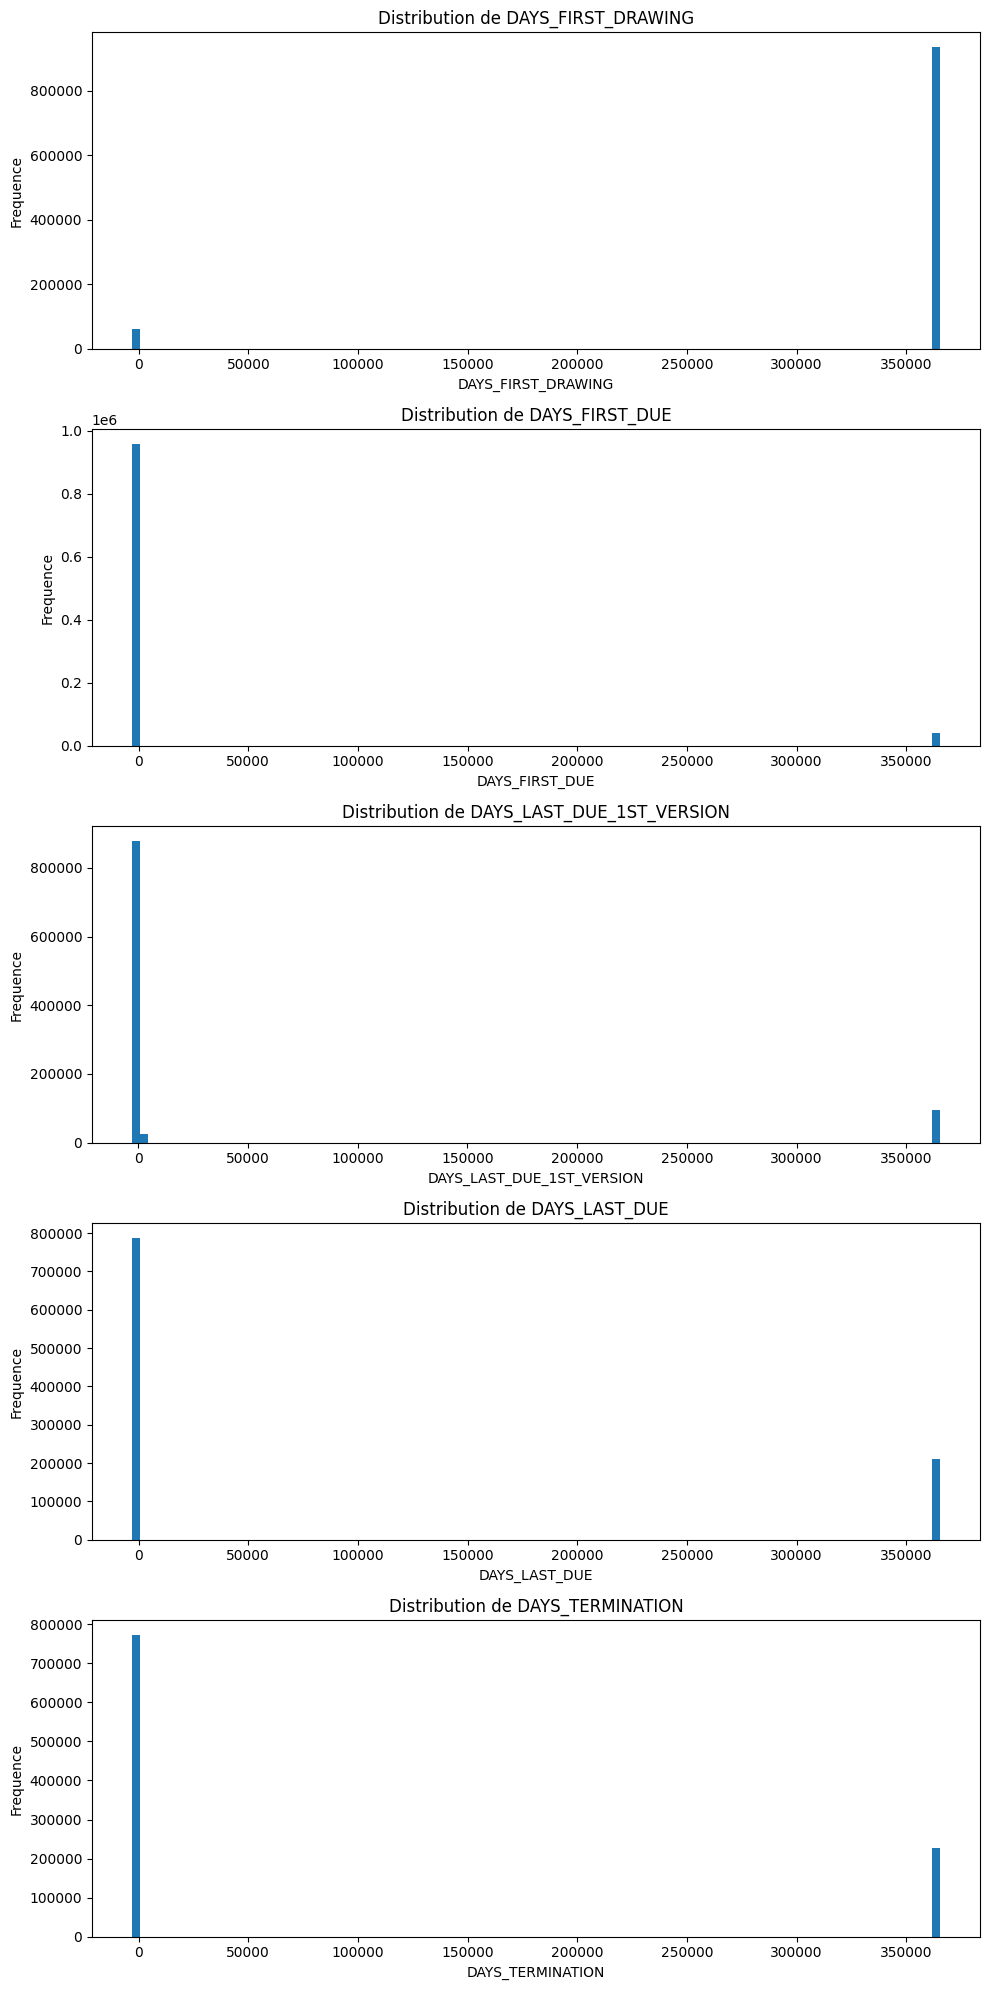

In [41]:
# Nom des features avec valeurs abérantes
valeur_aberante_feat = [
    'DAYS_FIRST_DRAWING',
    'DAYS_FIRST_DUE',
    'DAYS_LAST_DUE_1ST_VERSION',
    'DAYS_LAST_DUE',
    'DAYS_TERMINATION'
]

# Histogramme des features
fig, axs = plt.subplots(len(valeur_aberante_feat), figsize=(10, 20))

# POUR chaque feature
for i, col in enumerate(valeur_aberante_feat):
    axs[i].hist(previous_app[col].dropna(), bins=100)
    axs[i].set_title(f'Distribution de {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Frequence')

# Affichage
plt.tight_layout()
plt.show()

Alors que toutes les valeurs de ces features sont censées être négatives, nous observons groupe de valeur positives et très élevées avec la valeur 365_243 jours. Ce qui correspond à 1_000 ans (365_243 / 365,24).

*Ces valeurs sont donc abérantes et à remplacer par des NaN.*

### <span style='background:purple'>b/ Application data engineering</span>

Nous réalisons le feature engineering suivant :

- Encodage des variables catégorielles :
  - LabelEncoder si <=2 valeurs uniques
  - OneHotEncoder si >2 valeurs uniques

- Suppression des valeurs abérantes de :
  - DAYS_EMPLOYED
  - DAYS_FIRST_DUE
  - DAYS_LAST_DUE_1ST_VERSION
  - DAYS_LAST_DUE
  - DAYS_TERMINATION

- Création de nouvelles features :
  - 'APP_CREDIT_PERC' : proportion du montant de l'ancien crédit demandé par le client par rapport au montant de l'ancien crédit accordé.

- Aggrégation de previous_application par **SK_ID_CURR**:
  - features numériques : min, max, mean, var (selon la feature)
  - features catégorielles : mean

- Aggrégation de previous_application par **SK_ID_CURR** pour les crédits accordés

- Aggrégation de previous_application par **SK_ID_CURR** pour les crédits refusés

In [1]:
previous_app = feature_engin_previous_application(
    previous_app,
    valeur_aberante_feat
)

In [ ]:
print("Dimensions previous_app:", previous_app.shape)

Dimensions previous_app: (338857, 231)


Nous ajoutons ce dataframe au dataframe principal.

In [ ]:
df_merged = df_merged.join(previous_app, how='left', on='SK_ID_CURR')
display(df_merged)

# Suppression variable pour libérer de la mémoire
del previous_app

,index,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,...,PREV_PRODUCT_COMBINATION_Cash_MEAN,PREV_PRODUCT_COMBINATION_Cash Street high_MEAN,PREV_PRODUCT_COMBINATION_Cash Street low_MEAN,PREV_PRODUCT_COMBINATION_Cash Street middle_MEAN,PREV_PRODUCT_COMBINATION_Cash X Sell high_MEAN,PREV_PRODUCT_COMBINATION_Cash X Sell low_MEAN,PREV_PRODUCT_COMBINATION_Cash X Sell middle_MEAN,PREV_PRODUCT_COMBINATION_POS household with interest_MEAN,PREV_PRODUCT_COMBINATION_POS household without interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry without interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile with interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN,PREV_PRODUCT_COMBINATION_POS other with interest_MEAN,PREV_PRODUCT_COMBINATION_POS others without interest_MEAN,APPROVED_AMT_ANNUITY_MIN,APPROVED_AMT_ANNUITY_MAX,APPROVED_AMT_ANNUITY_MEAN,APPROVED_AMT_APPLICATION_MIN,APPROVED_AMT_APPLICATION_MAX,APPROVED_AMT_APPLICATION_MEAN,APPROVED_AMT_CREDIT_MIN,APPROVED_AMT_CREDIT_MAX,APPROVED_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_APP_CREDIT_PERC_MEAN,APPROVED_APP_CREDIT_PERC_VAR,APPROVED_AMT_DOWN_PAYMENT_MIN,APPROVED_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_DOWN_PAYMENT_MEAN,APPROVED_AMT_GOODS_PRICE_MIN,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MIN,APPROVED_HOUR_APPR_PROCESS_START_MAX,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_RATE_DOWN_PAYMENT_MIN,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_RATE_DOWN_PAYMENT_MEAN,APPROVED_DAYS_DECISION_MIN,APPROVED_DAYS_DECISION_MAX,APPROVED_DAYS_DECISION_MEAN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_SUM,REFUSED_AMT_ANNUITY_MIN,REFUSED_AMT_ANNUITY_MAX,REFUSED_AMT_ANNUITY_MEAN,REFUSED_AMT_APPLICATION_MIN,REFUSED_AMT_APPLICATION_MAX,REFUSED_AMT_APPLICATION_MEAN,REFUSED_AMT_CREDIT_MIN,REFUSED_AMT_CREDIT_MAX,REFUSED_AMT_CREDIT_MEAN,REFUSED_APP_CREDIT_PERC_MIN,REFUSED_APP_CREDIT_PERC_MAX,REFUSED_APP_CREDIT_PERC_MEAN,REFUSED_APP_CREDIT_PERC_VAR,REFUSED_AMT_DOWN_PAYMENT_MIN,REFUSED_AMT_DOWN_PAYMENT_MAX,REFUSED_AMT_DOWN_PAYMENT_MEAN,REFUSED_AMT_GOODS_PRICE_MIN,REFUSED_AMT_GOODS_PRICE_MAX,REFUSED_AMT_GOODS_PRICE_MEAN,REFUSED_HOUR_APPR_PROCESS_START_MIN,REFUSED_HOUR_APPR_PROCESS_START_MAX,REFUSED_HOUR_APPR_PROCESS_START_MEAN,REFUSED_RATE_DOWN_PAYMENT_MIN,REFUSED_RATE_DOWN_PAYMENT_MAX,REFUSED_RATE_DOWN_PAYMENT_MEAN,REFUSED_DAYS_DECISION_MIN,REFUSED_DAYS_DECISION_MAX,REFUSED_DAYS_DECISION_MEAN,REFUSED_CNT_PAYMENT_MEAN,REFUSED_CNT_PAYMENT_SUM
0,0,100002,1.0,0,1,0,1,0,202500.0,4.07e+05,24700.5,3.51e+05,1.88e-02,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00e+00,0.00e+00,0

## <span style='background:green'>7/ Sauvegarde df_merged</span>


In [18]:
# Definir le chemin des fichiers nettoyés
chemin_clean = "./data/cleaned/"

# Obtenir une liste de tous les fichiers dans le repertoire
fichiers = os.listdir(chemin_clean)

# Chemin du fichier pickle
pickle_path = chemin_clean + 'df_merged.pickle'

# Vérifier si le fichier pickle existe
if os.path.exists(pickle_path):

    # Charger les données à partir du fichier pickle
    with open(pickle_path, 'rb') as handle:
        df_merged = pickle.load(handle)
    print("===> Données chargées à partir du fichier pickle <====\n")
else:
    print("===> Création du fichier pickle de df_merged <====\n")

    # Sauvegarder les données dans un fichier pickle
    with open(pickle_path, 'wb') as handle:
        pickle.dump(df_merged, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("\n===> Données sauvegardées dans un fichier pickle <====\n")

===> Données chargées à partir du fichier pickle <====



# <span style='background:blue'>Etape 3 : Nettoyage des données</span>

## <span style='background:green'>1/ Filtrage des valeurs infinies</span>

Nous supprimons les valeurs infinies qui pourraient être présentes dans le dataframe car cela posera problème pour les modèles de machine learning.

In [19]:
# Suppression des valeurs infinies
df_merged_clean_inf = df_merged.drop(
    df_merged.iloc[df_merged.values == np.inf].index
)

# Affichage du nombre de lignes supprimées et du df nettoyé
nbr_ligne_suppr = df_merged.shape[0] - df_merged_clean_inf.shape[0]
print(f"Drop de {nbr_ligne_suppr} lignes ayant des valeurs infinies.")
display(df_merged_clean_inf)

Drop de 20 lignes ayant des valeurs infinies.


,index,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,...,PREV_PRODUCT_COMBINATION_Cash_MEAN,PREV_PRODUCT_COMBINATION_Cash Street high_MEAN,PREV_PRODUCT_COMBINATION_Cash Street low_MEAN,PREV_PRODUCT_COMBINATION_Cash Street middle_MEAN,PREV_PRODUCT_COMBINATION_Cash X Sell high_MEAN,PREV_PRODUCT_COMBINATION_Cash X Sell low_MEAN,PREV_PRODUCT_COMBINATION_Cash X Sell middle_MEAN,PREV_PRODUCT_COMBINATION_POS household with interest_MEAN,PREV_PRODUCT_COMBINATION_POS household without interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry without interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile with interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN,PREV_PRODUCT_COMBINATION_POS other with interest_MEAN,PREV_PRODUCT_COMBINATION_POS others without interest_MEAN,APPROVED_AMT_ANNUITY_MIN,APPROVED_AMT_ANNUITY_MAX,APPROVED_AMT_ANNUITY_MEAN,APPROVED_AMT_APPLICATION_MIN,APPROVED_AMT_APPLICATION_MAX,APPROVED_AMT_APPLICATION_MEAN,APPROVED_AMT_CREDIT_MIN,APPROVED_AMT_CREDIT_MAX,APPROVED_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_APP_CREDIT_PERC_MEAN,APPROVED_APP_CREDIT_PERC_VAR,APPROVED_AMT_DOWN_PAYMENT_MIN,APPROVED_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_DOWN_PAYMENT_MEAN,APPROVED_AMT_GOODS_PRICE_MIN,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MIN,APPROVED_HOUR_APPR_PROCESS_START_MAX,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_RATE_DOWN_PAYMENT_MIN,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_RATE_DOWN_PAYMENT_MEAN,APPROVED_DAYS_DECISION_MIN,APPROVED_DAYS_DECISION_MAX,APPROVED_DAYS_DECISION_MEAN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_SUM,REFUSED_AMT_ANNUITY_MIN,REFUSED_AMT_ANNUITY_MAX,REFUSED_AMT_ANNUITY_MEAN,REFUSED_AMT_APPLICATION_MIN,REFUSED_AMT_APPLICATION_MAX,REFUSED_AMT_APPLICATION_MEAN,REFUSED_AMT_CREDIT_MIN,REFUSED_AMT_CREDIT_MAX,REFUSED_AMT_CREDIT_MEAN,REFUSED_APP_CREDIT_PERC_MIN,REFUSED_APP_CREDIT_PERC_MAX,REFUSED_APP_CREDIT_PERC_MEAN,REFUSED_APP_CREDIT_PERC_VAR,REFUSED_AMT_DOWN_PAYMENT_MIN,REFUSED_AMT_DOWN_PAYMENT_MAX,REFUSED_AMT_DOWN_PAYMENT_MEAN,REFUSED_AMT_GOODS_PRICE_MIN,REFUSED_AMT_GOODS_PRICE_MAX,REFUSED_AMT_GOODS_PRICE_MEAN,REFUSED_HOUR_APPR_PROCESS_START_MIN,REFUSED_HOUR_APPR_PROCESS_START_MAX,REFUSED_HOUR_APPR_PROCESS_START_MEAN,REFUSED_RATE_DOWN_PAYMENT_MIN,REFUSED_RATE_DOWN_PAYMENT_MAX,REFUSED_RATE_DOWN_PAYMENT_MEAN,REFUSED_DAYS_DECISION_MIN,REFUSED_DAYS_DECISION_MAX,REFUSED_DAYS_DECISION_MEAN,REFUSED_CNT_PAYMENT_MEAN,REFUSED_CNT_PAYMENT_SUM
0,0,100002,1.0,0,1,0,1,0,202500.0,4.07e+05,24700.5,3.51e+05,1.88e-02,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00e+00,0.00e+00,0

## <span style='background:green'>2/ Filtrages des features à valeur unique</span>

Nous supprimons les features qui n'ont qu'une seule valeur unique car elles ne sont pas informatives pour les modèles de machine learning.

In [20]:
# Vérifier si il y a une feature avec une valeur unique
unique_feat = [
    col for col in df_merged_clean_inf.columns if df_merged_clean_inf[col].nunique() == 1
]

# SI il y a des features avec une valeur unique ALORS on les supprrime
if unique_feat:
    print("Features avec une valeur unique : ", unique_feat)
    df_merged_clean_uniq = df_merged_clean_inf.drop(columns=unique_feat)
    print(f"\n {len(unique_feat)} feat à 1 valeur unique ont été supprimées.")
else:
    print("Il n'y a pas de features avec une valeur unique.")

display(df_merged_clean_uniq)

Features avec une valeur unique :  ['CC_NAME_CONTRACT_STATUS_Approved_MIN', 'CC_NAME_CONTRACT_STATUS_Refused_MIN', 'CC_NAME_CONTRACT_STATUS_Sent proposal_MIN']

 3 feat à 1 valeur unique ont été supprimées.


,index,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,...,PREV_PRODUCT_COMBINATION_Cash_MEAN,PREV_PRODUCT_COMBINATION_Cash Street high_MEAN,PREV_PRODUCT_COMBINATION_Cash Street low_MEAN,PREV_PRODUCT_COMBINATION_Cash Street middle_MEAN,PREV_PRODUCT_COMBINATION_Cash X Sell high_MEAN,PREV_PRODUCT_COMBINATION_Cash X Sell low_MEAN,PREV_PRODUCT_COMBINATION_Cash X Sell middle_MEAN,PREV_PRODUCT_COMBINATION_POS household with interest_MEAN,PREV_PRODUCT_COMBINATION_POS household without interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry without interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile with interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN,PREV_PRODUCT_COMBINATION_POS other with interest_MEAN,PREV_PRODUCT_COMBINATION_POS others without interest_MEAN,APPROVED_AMT_ANNUITY_MIN,APPROVED_AMT_ANNUITY_MAX,APPROVED_AMT_ANNUITY_MEAN,APPROVED_AMT_APPLICATION_MIN,APPROVED_AMT_APPLICATION_MAX,APPROVED_AMT_APPLICATION_MEAN,APPROVED_AMT_CREDIT_MIN,APPROVED_AMT_CREDIT_MAX,APPROVED_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_APP_CREDIT_PERC_MEAN,APPROVED_APP_CREDIT_PERC_VAR,APPROVED_AMT_DOWN_PAYMENT_MIN,APPROVED_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_DOWN_PAYMENT_MEAN,APPROVED_AMT_GOODS_PRICE_MIN,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MIN,APPROVED_HOUR_APPR_PROCESS_START_MAX,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_RATE_DOWN_PAYMENT_MIN,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_RATE_DOWN_PAYMENT_MEAN,APPROVED_DAYS_DECISION_MIN,APPROVED_DAYS_DECISION_MAX,APPROVED_DAYS_DECISION_MEAN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_SUM,REFUSED_AMT_ANNUITY_MIN,REFUSED_AMT_ANNUITY_MAX,REFUSED_AMT_ANNUITY_MEAN,REFUSED_AMT_APPLICATION_MIN,REFUSED_AMT_APPLICATION_MAX,REFUSED_AMT_APPLICATION_MEAN,REFUSED_AMT_CREDIT_MIN,REFUSED_AMT_CREDIT_MAX,REFUSED_AMT_CREDIT_MEAN,REFUSED_APP_CREDIT_PERC_MIN,REFUSED_APP_CREDIT_PERC_MAX,REFUSED_APP_CREDIT_PERC_MEAN,REFUSED_APP_CREDIT_PERC_VAR,REFUSED_AMT_DOWN_PAYMENT_MIN,REFUSED_AMT_DOWN_PAYMENT_MAX,REFUSED_AMT_DOWN_PAYMENT_MEAN,REFUSED_AMT_GOODS_PRICE_MIN,REFUSED_AMT_GOODS_PRICE_MAX,REFUSED_AMT_GOODS_PRICE_MEAN,REFUSED_HOUR_APPR_PROCESS_START_MIN,REFUSED_HOUR_APPR_PROCESS_START_MAX,REFUSED_HOUR_APPR_PROCESS_START_MEAN,REFUSED_RATE_DOWN_PAYMENT_MIN,REFUSED_RATE_DOWN_PAYMENT_MAX,REFUSED_RATE_DOWN_PAYMENT_MEAN,REFUSED_DAYS_DECISION_MIN,REFUSED_DAYS_DECISION_MAX,REFUSED_DAYS_DECISION_MEAN,REFUSED_CNT_PAYMENT_MEAN,REFUSED_CNT_PAYMENT_SUM
0,0,100002,1.0,0,1,0,1,0,202500.0,4.07e+05,24700.5,3.51e+05,1.88e-02,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00e+00,0.00e+00,0

3:80: E501 line too long (89 > 79 characters)


## <span style='background:green'>3/ Filtrage par taux de remplissage</span>

Nous supprimons les features qui ont un taux de remplissage inférieur < 50% car elles ne sont pas informatives pour les modèles de machine learning.

In [21]:
# Tableau et matrice des valeurs manquantes
valeur_manquante_text_graph(df_merged_clean_uniq, False, False)

Valeurs manquantes (Nan) : 69368053 / 272872946 données (25.42 %)
586 / 766 colonne(s) concernée(s)


In [22]:
# Seuil de remplissage
seuil_remplissage = 0.50

# Suppression des features possédant plus de valeurs manquantes que le seuil
df_merged_clean_rempli = df_merged_clean_uniq.dropna(
    thresh=int(df_merged_clean_uniq.shape[0] * seuil_remplissage),
    axis=1
)

# Comptage et affichage du nombre de features supprimées
nbr_feat_supp = df_merged_clean_uniq.shape[1] - df_merged_clean_rempli.shape[1]
print(
    "Drop de {} features possedant plus de {}% de valeurs manquantes.".format(
        nbr_feat_supp,
        1 - ((seuil_remplissage) * 100)
    )
)

Drop de 224 features possedant plus de 50.0% de valeurs manquantes.


In [23]:
# Tableau et matrice des valeurs manquantes
valeur_manquante_text_graph(df_merged_clean_rempli, False, False)

Valeurs manquantes (Nan) : 13618060 / 193077202 données (7.05 %)


362 / 542 colonne(s) concernée(s)


Nous avons réduit le dataframe de 224 features pour en garder encore 542.

In [24]:
display(df_merged_clean_rempli)

,index,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,LIVINGAREA_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,LIVINGAREA_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,LIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,...,PREV_NAME_PORTFOLIO_XNA_MEAN,PREV_NAME_PRODUCT_TYPE_XNA_MEAN,PREV_NAME_PRODUCT_TYPE_walk in_MEAN,PREV_NAME_PRODUCT_TYPE_x sell_MEAN,PREV_CHANNEL_TYPE_AP Cash loan _MEAN,PREV_CHANNEL_TYPE_Car dealer_MEAN,PREV_CHANNEL_TYPE_Channel of corporate sales_MEAN,PREV_CHANNEL_TYPE_Contact center_MEAN,PREV_CHANNEL_TYPE_Country wide_MEAN,PREV_CHANNEL_TYPE_Credit and cash offices_MEAN,PREV_CHANNEL_TYPE_Regional Local_MEAN,PREV_CHANNEL_TYPE_Stone_MEAN,PREV_NAME_SELLER_INDUSTRY_Auto technology_MEAN,PREV_NAME_SELLER_INDUSTRY_Clothing_MEAN,PREV_NAME_SELLER_INDUSTRY_Connectivity_MEAN,PREV_NAME_SELLER_INDUSTRY_Construction_MEAN,PREV_NAME_SELLER_INDUSTRY_Consumer electronics_MEAN,PREV_NAME_SELLER_INDUSTRY_Furniture_MEAN,PREV_NAME_SELLER_INDUSTRY_Industry_MEAN,PREV_NAME_SELLER_INDUSTRY_Jewelry_MEAN,PREV_NAME_SELLER_INDUSTRY_MLM partners_MEAN,PREV_NAME_SELLER_INDUSTRY_Tourism_MEAN,PREV_NAME_SELLER_INDUSTRY_XNA_MEAN,PREV_NAME_YIELD_GROUP_XNA_MEAN,PREV_NAME_YIELD_GROUP_high_MEAN,PREV_NAME_YIELD_GROUP_low_action_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,PREV_NAME_YIELD_GROUP_middle_MEAN,PREV_PRODUCT_COMBINATION_Card Street_MEAN,PREV_PRODUCT_COMBINATION_Card X Sell_MEAN,PREV_PRODUCT_COMBINATION_Cash_MEAN,PREV_PRODUCT_COMBINATION_Cash Street high_MEAN,PREV_PRODUCT_COMBINATION_Cash Street low_MEAN,PREV_PRODUCT_COMBINATION_Cash Street middle_MEAN,PREV_PRODUCT_COMBINATION_Cash X Sell high_MEAN,PREV_PRODUCT_COMBINATION_Cash X Sell low_MEAN,PREV_PRODUCT_COMBINATION_Cash X Sell middle_MEAN,PREV_PRODUCT_COMBINATION_POS household with interest_MEAN,PREV_PRODUCT_COMBINATION_POS household without interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry without interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile with interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN,PREV_PRODUCT_COMBINATION_POS other with interest_MEAN,PREV_PRODUCT_COMBINATION_POS others without interest_MEAN,APPROVED_AMT_ANNUITY_MIN,APPROVED_AMT_ANNUITY_MAX,APPROVED_AMT_ANNUITY_MEAN,APPROVED_AMT_APPLICATION_MIN,APPROVED_AMT_APPLICATION_MAX,APPROVED_AMT_APPLICATION_MEAN,APPROVED_AMT_CREDIT_MIN,APPROVED_AMT_CREDIT_MAX,APPROVED_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_APP_CREDIT_PERC_MEAN,APPROVED_APP_CREDIT_PERC_VAR,APPROVED_AMT_DOWN_PAYMENT_MIN,APPROVED_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_DOWN_PAYMENT_MEAN,APPROVED_AMT_GOODS_PRICE_MIN,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MIN,APPROVED_HOUR_APPR_PROCESS_START_MAX,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_RATE_DOWN_PAYMENT_MIN,APPROVED_R

## <span style='background:green'>4/ Transformation des booléens en numérique</span>

Nous constatons qu'il existe toujours des features booléennes dans notre dataframe. 

In [25]:
# Compter le nombre de valeurs booléennes
num_bools_avt = df_merged_clean_rempli.map(
    lambda x: isinstance(x, bool)
).sum().sum()

# Afficher le nombre de valeurs booléennes
print(f"\nNombre de valeurs booléennes : {num_bools_avt}")
df_merged_clean_rempli.info()


Nombre de valeurs booléennes : 46666261
<class 'pandas.core.frame.DataFrame'>
Index: 356231 entries, 0 to 356254
Columns: 542 entries, index to APPROVED_CNT_PAYMENT_SUM
dtypes: bool(131), float64(367), int32(4), int64(40)
memory usage: 1.1 GB


Nous transformons les valeurs booléennes en numériques pour les modèles de machine learning.

Nous remplaçons les valeurs True par 1 et les valeurs False par 0.

In [26]:
# Instanciez la classe BooleanToInt
bool_to_int = BooleanToInt()

# Utilisez la méthode fit pour apprendre les noms des caractéristiques
bool_to_int.fit(df_merged_clean_rempli)

# Utilisez la méthode transform pour convertir les valeurs booléennes en int
df_merged_clean_bool = bool_to_int.transform(df_merged_clean_rempli)

Nous vérifions qu'il n'y a plus de valeurs booléennes dans notre dataframe. 

In [27]:
# Compter le nombre de valeurs booléennes
num_bools_aps = df_merged_clean_bool.map(
    lambda x: isinstance(x, bool)
).sum().sum()

# Afficher le nombre de valeurs booléennes
print(f"Nombre de valeurs booléennes : {num_bools_aps}")
df_merged_clean_bool.info()

Nombre de valeurs booléennes : 0
<class 'pandas.core.frame.DataFrame'>
Index: 356231 entries, 0 to 356254
Columns: 542 entries, index to APPROVED_CNT_PAYMENT_SUM
dtypes: float64(367), int32(135), int64(40)
memory usage: 1.3 GB


In [28]:
display(df_merged_clean_bool)

,index,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,LIVINGAREA_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,LIVINGAREA_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,LIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,...,PREV_NAME_PORTFOLIO_XNA_MEAN,PREV_NAME_PRODUCT_TYPE_XNA_MEAN,PREV_NAME_PRODUCT_TYPE_walk in_MEAN,PREV_NAME_PRODUCT_TYPE_x sell_MEAN,PREV_CHANNEL_TYPE_AP Cash loan _MEAN,PREV_CHANNEL_TYPE_Car dealer_MEAN,PREV_CHANNEL_TYPE_Channel of corporate sales_MEAN,PREV_CHANNEL_TYPE_Contact center_MEAN,PREV_CHANNEL_TYPE_Country wide_MEAN,PREV_CHANNEL_TYPE_Credit and cash offices_MEAN,PREV_CHANNEL_TYPE_Regional Local_MEAN,PREV_CHANNEL_TYPE_Stone_MEAN,PREV_NAME_SELLER_INDUSTRY_Auto technology_MEAN,PREV_NAME_SELLER_INDUSTRY_Clothing_MEAN,PREV_NAME_SELLER_INDUSTRY_Connectivity_MEAN,PREV_NAME_SELLER_INDUSTRY_Construction_MEAN,PREV_NAME_SELLER_INDUSTRY_Consumer electronics_MEAN,PREV_NAME_SELLER_INDUSTRY_Furniture_MEAN,PREV_NAME_SELLER_INDUSTRY_Industry_MEAN,PREV_NAME_SELLER_INDUSTRY_Jewelry_MEAN,PREV_NAME_SELLER_INDUSTRY_MLM partners_MEAN,PREV_NAME_SELLER_INDUSTRY_Tourism_MEAN,PREV_NAME_SELLER_INDUSTRY_XNA_MEAN,PREV_NAME_YIELD_GROUP_XNA_MEAN,PREV_NAME_YIELD_GROUP_high_MEAN,PREV_NAME_YIELD_GROUP_low_action_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,PREV_NAME_YIELD_GROUP_middle_MEAN,PREV_PRODUCT_COMBINATION_Card Street_MEAN,PREV_PRODUCT_COMBINATION_Card X Sell_MEAN,PREV_PRODUCT_COMBINATION_Cash_MEAN,PREV_PRODUCT_COMBINATION_Cash Street high_MEAN,PREV_PRODUCT_COMBINATION_Cash Street low_MEAN,PREV_PRODUCT_COMBINATION_Cash Street middle_MEAN,PREV_PRODUCT_COMBINATION_Cash X Sell high_MEAN,PREV_PRODUCT_COMBINATION_Cash X Sell low_MEAN,PREV_PRODUCT_COMBINATION_Cash X Sell middle_MEAN,PREV_PRODUCT_COMBINATION_POS household with interest_MEAN,PREV_PRODUCT_COMBINATION_POS household without interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry without interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile with interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN,PREV_PRODUCT_COMBINATION_POS other with interest_MEAN,PREV_PRODUCT_COMBINATION_POS others without interest_MEAN,APPROVED_AMT_ANNUITY_MIN,APPROVED_AMT_ANNUITY_MAX,APPROVED_AMT_ANNUITY_MEAN,APPROVED_AMT_APPLICATION_MIN,APPROVED_AMT_APPLICATION_MAX,APPROVED_AMT_APPLICATION_MEAN,APPROVED_AMT_CREDIT_MIN,APPROVED_AMT_CREDIT_MAX,APPROVED_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_APP_CREDIT_PERC_MEAN,APPROVED_APP_CREDIT_PERC_VAR,APPROVED_AMT_DOWN_PAYMENT_MIN,APPROVED_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_DOWN_PAYMENT_MEAN,APPROVED_AMT_GOODS_PRICE_MIN,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MIN,APPROVED_HOUR_APPR_PROCESS_START_MAX,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_RATE_DOWN_PAYMENT_MIN,APPROVED_R

## <span style='background:green'>5/ Filtrage des features corrélées</span>

Nous observons tout d'abord si des features sont corrélées positivement ou négativement à la target (corrélation > 0.5).

In [29]:
# Matrice de corrélation
corr_matrix = df_merged_clean_bool.corr()

# Détection des corrélations avec TARGET (> 0.5)
detecteur_correlation_sup_target(
    corr_matrix,
    target_feature='TARGET',
    seuil=0.5
)

,Feature cible,Feature associée,Corrélation


Il n'y a pas de feature corrélée à la target.

Nous filtrons ensuite les features fortement corrélées entre elles (positivement et négativement) dans tout le dataframe (>0.5) pour ne garder qu'une seule des 2 features et ainsi éviter le sur-apprentissage et améliorer la stabilite du modèle de machine learning que nous créerons par la suite.

In [30]:
# Détection des corrélations (> 0.5)
df_to_drop, to_drop = supprimer_caracteristiques_corr(
    corr_matrix,
    seuil=0.5
)

# Afficher le DataFrame des caractéristiques à supprimer et leur nombre
display(df_to_drop)
print(f"\n{len(df_to_drop)} features à supprimer.")

,,Corrélation
index,index,1.00
PREV_NAME_CONTRACT_TYPE_Cash loans_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_XAP_MEAN,1.00
PREV_AMT_APPLICATION_MAX,PREV_AMT_GOODS_PRICE_MAX,1.00
FLAG_EMP_PHONE,ORGANIZATION_TYPE_XNA,1.00
NAME_INCOME_TYPE_Pensioner,ORGANIZATION_TYPE_XNA,1.00
FLAG_EMP_PHONE,NAME_INCOME_TYPE_Pensioner,1.00
INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_PAYMENT_MAX,1.00
OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,1.00
INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_SUM,1.00
FLOORSMAX_AVG,FLOORSMAX_MEDI,1.00


,Feature à supprimer
91,ACTIVE_AMT_CREDIT_SUM_DEBT_MAX
144,ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN
69,ACTIVE_AMT_CREDIT_SUM_DEBT_SUM
77,ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN
187,ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM
...,...
9,REGION_RATING_CLIENT_W_CITY
143,TOTALAREA_MODE
17,YEARS_BEGINEXPLUATATION_MEDI
46,YEARS_BEGINEXPLUATATION_MODE



192 features à supprimer.


Nous supprimons ces 192 features pour diminuer la taille de notre Dataframe.

**La suppression de ces features fortement corrélées entre elles permet d'éviter le data leakage des modèles de machine learning.**

In [31]:
# Supprimer les features sélectionnées
df_merged_clean_corr = df_merged_clean_bool.drop(columns=to_drop)

# Afficher le DataFrame après suppression des caractéristiques
display(df_merged_clean_corr)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spouse partner,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,...,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_NAME_CONTRACT_STATUS_Unused offer_MEAN,PREV_NAME_PAYMENT_TYPE_Cash through the bank_MEAN,PREV_NAME_PAYMENT_TYPE_Cashless from the account of the employer_MEAN,PREV_NAME_PAYMENT_TYPE_Non cash from your account_MEAN,PREV_CODE_REJECT_REASON_CLIENT_MEAN,PREV_CODE_REJECT_REASON_LIMIT_MEAN,PREV_CODE_REJECT_REASON_SCO_MEAN,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_CODE_REJECT_REASON_SYSTEM_MEAN,PREV_CODE_REJECT_REASON_VERIF_MEAN,PREV_CODE_REJECT_REASON_XNA_MEAN,PREV_NAME_TYPE_SUITE_Children_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,PREV_NAME_TYPE_SUITE_Group of people_MEAN,PREV_NAME_TYPE_SUITE_Other_A_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,PREV_NAME_TYPE_SUITE_Spouse partner_MEAN,PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,PREV_NAME_CLIENT_TYPE_Refreshed_MEAN,PREV_NAME_CLIENT_TYPE_XNA_MEAN,PREV_NAME_GOODS_CATEGORY_Additional Service_MEAN,PREV_NAME_GOODS_CATEGORY_Animals_MEAN,PREV_NAME_GOODS_CATEGORY_Audio Video_MEAN,PREV_NAME_GOODS_CATEGORY_Auto Accessories_MEAN,PREV_NAME_GOODS_CATEGORY_Clothing and Accessories_MEAN,PREV_NAME_GOODS_CATEGORY_Computers_MEAN,PREV_NAME_GOODS_CATEGORY_Construction Materials_MEAN,PREV_NAME_GOODS_CATEGORY_Consumer Electronics_MEAN,PREV_NAME_GOODS_CATEGORY_Direct Sales_MEAN,PREV_NAME_GOODS_CATEGORY_Education_MEAN,PREV_NAME_GOODS_CATEGORY_Fitness_MEAN,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,PREV_NAME_GOODS_CATEGORY_Gardening_MEAN,PREV_NAME_GOODS_CATEGORY_Homewares_MEAN,PREV_NAME_GOODS_CATEGORY_House Construction_MEAN,PREV_NAME_GOODS_CATEGORY_Insurance_MEAN,PREV_NAME_GOODS_CATEGORY_Jewelry_MEAN,PREV_NAME_GOODS_CATEGORY_Medical Supplies_MEAN,PREV_NAME_GOODS_CATEGORY_Medicine_MEAN,PREV_NAME_GOODS_CATEGORY_Mobile_MEAN,PREV_NAME_GOODS_CATEGORY_Office Appliances_MEAN,PREV_NAME_GOODS_CATEGORY_Other_MEAN,PREV_NAME_GOODS_CATEGORY_Photo Cinema Equipment_MEAN,PREV_NAME_GOODS_CATEGORY_Sport and Leisure_MEAN,PREV_NAME_GOODS_CATEGORY_Tourism_MEAN,PREV_NAME_GOODS_CATEGORY_Vehicles_MEAN,PREV_NAME_GOODS_CATEGORY_Weapon_MEAN,PREV_NAME_PORTFOLIO_Cars_MEAN,PREV_NAME_PORTFOLIO_Cash_MEAN,PREV_NAME_PRODUCT_TYPE_walk in_MEAN,PREV_CHANNEL_TYPE_AP Cash loan _MEAN,PREV_CHANNEL_TYPE_Channel of corporate sales_MEAN,PREV_CHANNEL_TYPE_Contact center_MEAN,PREV_CHANNEL_TYPE_Country wide_MEAN,PREV_CHANNEL_TYPE_Regional Local_MEAN,PREV_CHANNEL_TYPE_Stone_MEAN,PREV_NAME_SELLER_INDUSTRY_Consumer electronics_MEAN,PREV_NAME_SELLER

## <span style='background:green'>6/ Séparation des datasets de train_test</span>

Nous séparons le dataframe principal en 2 datasets : train et test. Nous utilisons la logique du dataset initial, à savoir que les lignes avec la TARGET sont le train et les lignes sans la TARGET sont le test.

In [32]:
# train
train_df = df_merged_clean_corr[df_merged_clean_corr['TARGET'].notnull()]
train_percentage = (train_df.shape[0] / df_merged_clean_corr.shape[0]) * 100
print("Dimensions train_df:", train_df.shape)
print(f"Le dataset de train représente {train_percentage:.1f}% du total.")

# test
test_df = df_merged_clean_corr[df_merged_clean_corr['TARGET'].isnull()]
test_percentage = (test_df.shape[0] / df_merged_clean_corr.shape[0]) * 100
print("\nDimensions test_df:", test_df.shape)
print(f"Le dataset de test représente {test_percentage:.1f}% du total.")

Dimensions train_df: (307488, 350)
Le dataset de train représente 86.3% du total.

Dimensions test_df: (48743, 350)
Le dataset de test représente 13.7% du total.


La répartition des données est convenable: 
- 86% des données sont dans le train
- 13% des données sont dans le test

## <span style='background:green'>7/ Cast de la target</span>

Nous remarquons que la target est de type float64, nous la castons en int64 puisqu'elle ne peut être que 0 ou 1.

In [33]:
# Afficher le type de données avant de les changer
print("Type de données avant changement :")
print(train_df[['TARGET']].dtypes)

# Changer le type de données de la target en int64
train_df = train_df.astype({'TARGET': 'int64'})
print("\nType de données après changement :")
print(train_df[['TARGET']].dtypes)

# Compter les valeurs de la target (en %)
print()
print(train_df['TARGET'].value_counts(normalize=True))

Type de données avant changement :
TARGET    float64
dtype: object



Type de données après changement :
TARGET    int64
dtype: object

TARGET
0    0.92
1    0.08
Name: proportion, dtype: float64


Un net déséquilibre entre les 2 classes est observé (92% / 8%). Nous devrons prendre cela en compte lors de la modélisation.

# <span style='background:blue'>Etape 4 : Exportation des dataframes nettoyés</span>

Nous visualisons l'aspect du dataframe train nettoyé.

In [34]:
train_df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spouse partner,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,...,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_NAME_CONTRACT_STATUS_Unused offer_MEAN,PREV_NAME_PAYMENT_TYPE_Cash through the bank_MEAN,PREV_NAME_PAYMENT_TYPE_Cashless from the account of the employer_MEAN,PREV_NAME_PAYMENT_TYPE_Non cash from your account_MEAN,PREV_CODE_REJECT_REASON_CLIENT_MEAN,PREV_CODE_REJECT_REASON_LIMIT_MEAN,PREV_CODE_REJECT_REASON_SCO_MEAN,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_CODE_REJECT_REASON_SYSTEM_MEAN,PREV_CODE_REJECT_REASON_VERIF_MEAN,PREV_CODE_REJECT_REASON_XNA_MEAN,PREV_NAME_TYPE_SUITE_Children_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,PREV_NAME_TYPE_SUITE_Group of people_MEAN,PREV_NAME_TYPE_SUITE_Other_A_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,PREV_NAME_TYPE_SUITE_Spouse partner_MEAN,PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,PREV_NAME_CLIENT_TYPE_Refreshed_MEAN,PREV_NAME_CLIENT_TYPE_XNA_MEAN,PREV_NAME_GOODS_CATEGORY_Additional Service_MEAN,PREV_NAME_GOODS_CATEGORY_Animals_MEAN,PREV_NAME_GOODS_CATEGORY_Audio Video_MEAN,PREV_NAME_GOODS_CATEGORY_Auto Accessories_MEAN,PREV_NAME_GOODS_CATEGORY_Clothing and Accessories_MEAN,PREV_NAME_GOODS_CATEGORY_Computers_MEAN,PREV_NAME_GOODS_CATEGORY_Construction Materials_MEAN,PREV_NAME_GOODS_CATEGORY_Consumer Electronics_MEAN,PREV_NAME_GOODS_CATEGORY_Direct Sales_MEAN,PREV_NAME_GOODS_CATEGORY_Education_MEAN,PREV_NAME_GOODS_CATEGORY_Fitness_MEAN,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,PREV_NAME_GOODS_CATEGORY_Gardening_MEAN,PREV_NAME_GOODS_CATEGORY_Homewares_MEAN,PREV_NAME_GOODS_CATEGORY_House Construction_MEAN,PREV_NAME_GOODS_CATEGORY_Insurance_MEAN,PREV_NAME_GOODS_CATEGORY_Jewelry_MEAN,PREV_NAME_GOODS_CATEGORY_Medical Supplies_MEAN,PREV_NAME_GOODS_CATEGORY_Medicine_MEAN,PREV_NAME_GOODS_CATEGORY_Mobile_MEAN,PREV_NAME_GOODS_CATEGORY_Office Appliances_MEAN,PREV_NAME_GOODS_CATEGORY_Other_MEAN,PREV_NAME_GOODS_CATEGORY_Photo Cinema Equipment_MEAN,PREV_NAME_GOODS_CATEGORY_Sport and Leisure_MEAN,PREV_NAME_GOODS_CATEGORY_Tourism_MEAN,PREV_NAME_GOODS_CATEGORY_Vehicles_MEAN,PREV_NAME_GOODS_CATEGORY_Weapon_MEAN,PREV_NAME_PORTFOLIO_Cars_MEAN,PREV_NAME_PORTFOLIO_Cash_MEAN,PREV_NAME_PRODUCT_TYPE_walk in_MEAN,PREV_CHANNEL_TYPE_AP Cash loan _MEAN,PREV_CHANNEL_TYPE_Channel of corporate sales_MEAN,PREV_CHANNEL_TYPE_Contact center_MEAN,PREV_CHANNEL_TYPE_Country wide_MEAN,PREV_CHANNEL_TYPE_Regional Local_MEAN,PREV_CHANNEL_TYPE_Stone_MEAN,PREV_NAME_SELLER_INDUSTRY_Consumer electronics_MEAN,PREV_NAME_SELLER

Nous visualisons l'aspect du dataframe test nettoyé.

In [35]:
test_df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spouse partner,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,...,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_NAME_CONTRACT_STATUS_Unused offer_MEAN,PREV_NAME_PAYMENT_TYPE_Cash through the bank_MEAN,PREV_NAME_PAYMENT_TYPE_Cashless from the account of the employer_MEAN,PREV_NAME_PAYMENT_TYPE_Non cash from your account_MEAN,PREV_CODE_REJECT_REASON_CLIENT_MEAN,PREV_CODE_REJECT_REASON_LIMIT_MEAN,PREV_CODE_REJECT_REASON_SCO_MEAN,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_CODE_REJECT_REASON_SYSTEM_MEAN,PREV_CODE_REJECT_REASON_VERIF_MEAN,PREV_CODE_REJECT_REASON_XNA_MEAN,PREV_NAME_TYPE_SUITE_Children_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,PREV_NAME_TYPE_SUITE_Group of people_MEAN,PREV_NAME_TYPE_SUITE_Other_A_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,PREV_NAME_TYPE_SUITE_Spouse partner_MEAN,PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,PREV_NAME_CLIENT_TYPE_Refreshed_MEAN,PREV_NAME_CLIENT_TYPE_XNA_MEAN,PREV_NAME_GOODS_CATEGORY_Additional Service_MEAN,PREV_NAME_GOODS_CATEGORY_Animals_MEAN,PREV_NAME_GOODS_CATEGORY_Audio Video_MEAN,PREV_NAME_GOODS_CATEGORY_Auto Accessories_MEAN,PREV_NAME_GOODS_CATEGORY_Clothing and Accessories_MEAN,PREV_NAME_GOODS_CATEGORY_Computers_MEAN,PREV_NAME_GOODS_CATEGORY_Construction Materials_MEAN,PREV_NAME_GOODS_CATEGORY_Consumer Electronics_MEAN,PREV_NAME_GOODS_CATEGORY_Direct Sales_MEAN,PREV_NAME_GOODS_CATEGORY_Education_MEAN,PREV_NAME_GOODS_CATEGORY_Fitness_MEAN,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,PREV_NAME_GOODS_CATEGORY_Gardening_MEAN,PREV_NAME_GOODS_CATEGORY_Homewares_MEAN,PREV_NAME_GOODS_CATEGORY_House Construction_MEAN,PREV_NAME_GOODS_CATEGORY_Insurance_MEAN,PREV_NAME_GOODS_CATEGORY_Jewelry_MEAN,PREV_NAME_GOODS_CATEGORY_Medical Supplies_MEAN,PREV_NAME_GOODS_CATEGORY_Medicine_MEAN,PREV_NAME_GOODS_CATEGORY_Mobile_MEAN,PREV_NAME_GOODS_CATEGORY_Office Appliances_MEAN,PREV_NAME_GOODS_CATEGORY_Other_MEAN,PREV_NAME_GOODS_CATEGORY_Photo Cinema Equipment_MEAN,PREV_NAME_GOODS_CATEGORY_Sport and Leisure_MEAN,PREV_NAME_GOODS_CATEGORY_Tourism_MEAN,PREV_NAME_GOODS_CATEGORY_Vehicles_MEAN,PREV_NAME_GOODS_CATEGORY_Weapon_MEAN,PREV_NAME_PORTFOLIO_Cars_MEAN,PREV_NAME_PORTFOLIO_Cash_MEAN,PREV_NAME_PRODUCT_TYPE_walk in_MEAN,PREV_CHANNEL_TYPE_AP Cash loan _MEAN,PREV_CHANNEL_TYPE_Channel of corporate sales_MEAN,PREV_CHANNEL_TYPE_Contact center_MEAN,PREV_CHANNEL_TYPE_Country wide_MEAN,PREV_CHANNEL_TYPE_Regional Local_MEAN,PREV_CHANNEL_TYPE_Stone_MEAN,PREV_NAME_SELLER_INDUSTRY_Consumer electronics_MEAN,PREV_NAME_SELLER


Nous allons sauvegarder les 2 datasets pour les utiliser dans nos modèles de machine learning.

In [36]:
# Chemin du dossier et nom des fichiers nettoyés
output_directory = "data/cleaned"
nomFichier_export_train = "application_train_cleaned.csv"
nomFichier_export_test = "application_test_cleaned.csv"

# Verification de l'existence du dossier
os.makedirs(output_directory, exist_ok=True)

# Chemin complet des fichier export
output_file_train = os.path.join(output_directory, nomFichier_export_train)
output_file_test = os.path.join(output_directory, nomFichier_export_test)

# export df nettoyés en CSV
train_df.to_csv(output_file_train, sep=",", encoding="latin-1")
test_df.to_csv(output_file_test, sep=",", encoding="latin-1")

# <span style='background:blue'>Conclusion</span>

Nous avons partiellement nettoyé les données et réalisé du feature engineering. Nous avons également joint les datasets entre eux pour obtenir un dataframe principal. Nous l'avons ensuite séparé en 2 datasets : **train** et **test**. Nous allons utiliser le train pour finaliser le nettoyage/feature engineering et réaliser des modèles de machine learning directement dans des pipelines au sein du prochain notebook.

In [37]:
# Afficher temps d'exécution du notebook
calculer_duree_notebook(start_time)

Durée execution notebook : 7 min 33 sec
